## Kaggle NY Taxi trip duration prediction


In [98]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# set Jupyter to display ALL output from a cell (not just last output)
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all" 

# set pandas and numpy options to make print format nicer
pd.set_option("display.width",100)
pd.set_option("display.max_columns",1000)
pd.set_option('display.max_colwidth', 80)
pd.set_option('display.max_rows', 500)
np.set_printoptions(linewidth=120, threshold=5000, edgeitems=10, suppress=True)

import warnings  # supress annoying seaborn/pandas deprecation warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
warnings.filterwarnings("ignore", category=FutureWarning)

## Read into dataframes, and add new features

In [128]:
%%time
# create train and test dataframes, with parsed data fields
train = pd.read_csv('train.csv', parse_dates=['pickup_datetime','dropoff_datetime'])
test  = pd.read_csv('test.csv',  parse_dates=['pickup_datetime'])
test_id = test.id.copy() # save test ids for later use in submitting files
print(train.shape, test.shape)

(1458644, 11) (625134, 9)
CPU times: user 5.23 s, sys: 496 ms, total: 5.72 s
Wall time: 5.75 s


In [129]:
%%time
# create new features from location, datetime fields, and others
def great_circle_distance(lat1, long1, lat2, long2):
    EARTH_RADIUS = 6371
    lat1 = np.radians(lat1); lat2 = np.radians(lat2); long1 = np.radians(long1); long2 = np.radians(long2)
    lat_diff  = lat2 - lat1; long_diff = long2 - long1
    temp = np.sin(lat_diff * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(long_diff * 0.5) ** 2
    return 2 * EARTH_RADIUS * np.arcsin(np.sqrt(temp))

def manhattan_distance(lat1, long1, lat2, long2):
    a = great_circle_distance(lat1, long1, lat1, long2)
    b = great_circle_distance(lat1, long1, lat2, long1)
    return a + b

def bearing(lat1, long1, lat2, long2):
    EARTH_RADIUS = 6371  # in km
    long_diff = np.radians(long2 - long1)
    lat1 = np.radians(lat1); lat2 = np.radians(lat2); long1 = np.radians(long1); long2 = np.radians(long2)
    long_diff = long2 - long1
    y = np.sin(long_diff) * np.cos(lat2)
    x = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(long_diff)
    return np.degrees(np.arctan2(y, x))

ny_public_holidays = pd.Series([pd.Timestamp('2016-01-01'), pd.Timestamp('2016-01-18'), pd.Timestamp('2016-02-15'),
                                pd.Timestamp('2016-05-30'), pd.Timestamp('2016-07-04'), pd.Timestamp('2016-09-05'),
                                pd.Timestamp('2016-10-10'), pd.Timestamp('2016-11-11'), pd.Timestamp('2016-11-24'),
                                pd.Timestamp('2016-12-26')])

train = train[train.trip_duration < 87000] # remove 4 outliers, more than 1 day
coords = np.vstack((train[['pickup_latitude', 'pickup_longitude']].values,
                    train[['dropoff_latitude', 'dropoff_longitude']].values,
                    test[['pickup_latitude', 'pickup_longitude']].values,
                    test[['dropoff_latitude', 'dropoff_longitude']].values))

from sklearn.decomposition import PCA        # create PCA model of locations to extract max differences
pca = PCA().fit(coords)                      

from sklearn.cluster import MiniBatchKMeans  # create cluster of pickup and dropoff locations
kmeans = MiniBatchKMeans(n_clusters=100, batch_size=10000).fit(coords) # was 100 clusters

# make same new features in both test and train
for data in (train, test):
    data['store_and_fwd_flag']   = data.store_and_fwd_flag.map({'N':0, 'Y':1})
    data['pickup_month_of_year'] = data.pickup_datetime.dt.month
    data['pickup_day_of_week']   = data.pickup_datetime.dt.dayofweek
    data['pickup_day_of_month']  = data.pickup_datetime.dt.day
    data['pickup_day_of_year']   = data.pickup_datetime.dt.dayofyear
    data['pickup_hour_of_day']   = data.pickup_datetime.dt.hour
    data['pickup_minute_of_day'] = np.round((data.pickup_datetime.dt.hour * 60 + \
                                             data.pickup_datetime.dt.minute + \
                                             data.pickup_datetime.dt.second / 60)).astype(int)
    data['pickup_quarter_hour']  = np.round((data.pickup_datetime.dt.hour * 4 + \
                                            (data.pickup_datetime.dt.minute + 
                                             data.pickup_datetime.dt.second / 60) / 15)).astype(int)
    data['holiday']              = data.pickup_datetime.dt.date.astype('datetime64[ns]'). \
                                             isin(ny_public_holidays).astype(int)
    data['distance_great_circle']= great_circle_distance(data['pickup_latitude'].values, 
                                                          data['pickup_longitude'].values, 
                                                          data['dropoff_latitude'].values, 
                                                          data['dropoff_longitude'].values)
    data['distance_manhattan']   = manhattan_distance(data['pickup_latitude'].values, 
                                                      data['pickup_longitude'].values, 
                                                      data['dropoff_latitude'].values, 
                                                      data['dropoff_longitude'].values)
    data['direction']            = bearing(data['pickup_latitude'].values, data['pickup_longitude'].values, 
                                                 data['dropoff_latitude'].values, data['dropoff_longitude'].values)
    data['center_latitude']      = (data['pickup_latitude'].values  + data['dropoff_latitude'].values) / 2
    data['center_longitude']     = (data['pickup_longitude'].values + data['dropoff_longitude'].values) / 2
    temp_pickup                  = pca.transform(data[['pickup_latitude', 'pickup_longitude']])
    temp_center                  = pca.transform(data[['center_latitude', 'center_longitude']])
    temp_dropoff                 = pca.transform(data[['dropoff_latitude', 'dropoff_longitude']])
    data['pickup_pca0']          = temp_pickup[:, 0]
    data['pickup_pca1']          = temp_pickup[:, 1]
    data['center_pca0']          = temp_center[:, 0]
    data['center_pca1']          = temp_center[:, 1]
    data['dropoff_pca0']         = temp_dropoff[:, 0]
    data['dropoff_pca1']         = temp_dropoff[:, 1]
    data['pickup_cluster']       = kmeans.predict(data[['pickup_latitude',  'pickup_longitude']])
    data['center_cluster']       = kmeans.predict(data[['center_latitude',  'center_longitude']])
    data['dropoff_cluster']      = kmeans.predict(data[['dropoff_latitude', 'dropoff_longitude']])
    
# fields only on train dataframe (used for identifying problem rows, not for model training)
# train['speed_great_circle'] = train.distance_great_circle / train.trip_duration * 60 * 60
# train['speed_manhattan']    = train.distance_manhattan / train.trip_duration * 60 * 60
train['log_trip_duration']  = np.log(train['trip_duration'] + 1)
train_y = train.log_trip_duration

fr1 = pd.read_csv('./data/fastest_routes_train_part_1.csv', usecols=['id','total_distance','total_travel_time','number_of_steps'])
fr2 = pd.read_csv('./data/fastest_routes_train_part_2.csv', usecols=['id', 'total_distance','total_travel_time','number_of_steps'])
test_street_info = pd.read_csv('./data/fastest_routes_test.csv',usecols=['id','total_distance','total_travel_time','number_of_steps'])
train_street_info = pd.concat((fr1, fr2))
train = train.merge(train_street_info, how='left', on='id')
test  = test.merge(test_street_info,   how='left', on='id')

train_backup = train.copy()

CPU times: user 34.3 s, sys: 6.55 s, total: 40.9 s
Wall time: 22 s


In [45]:
#adding weather gives worse results!!!
# weather = pd.read_csv('./data/KNYC_Metars.csv', parse_dates=['Time'])
# weather.head(3)

# weather['snow']= 1*(weather.Events=='Snow') + 1*(weather.Events=='Fog\n\t,\nSnow')
# weather['year'] = weather['Time'].dt.year
# weather['pickup_month_of_year'] = weather['Time'].dt.month
# weather['pickup_day_of_month'] = weather['Time'].dt.day
# weather['pickup_hour_of_day'] = weather['Time'].dt.hour
# # weather = weather[weather['year'] == 2016][['pickup_month_of_year','pickup_day_of_month','pickup_hour_of_day',
# #                                             'Temp.','Windchill', 'Heat Index','Humidity','Pressure', 'Dew Point', 
# #                                             'Visibility','Wind Speed','Gust Speed', 'Precip','snow']]
# weather = weather[weather['year'] == 2016][['pickup_month_of_year','pickup_day_of_month','pickup_hour_of_day',
#                                             'Dew Point', 'Temp.', 'Pressure']]
# weather.head(3)

# train = pd.merge(train, weather, on=['pickup_month_of_year', 'pickup_day_of_month', 'pickup_hour_of_day'], how='left')
# test =  pd.merge(test,  weather, on=['pickup_month_of_year', 'pickup_day_of_month', 'pickup_hour_of_day'], how='left')
# train_backup = train.copy()

,Time,Temp.,Windchill,Heat Index,Humidity,Pressure,Dew Point,Visibility,Wind Dir,Wind Speed,Gust Speed,Precip,Events,Conditions
0,2015-12-31 02:00:00,7.8,7.1,NaN,0.89,1017.0,6.1,8.0,NNE,5.6,0.0,0.8,None,Overcast
1,2015-12-31 03:00:00,7.2,5.9,NaN,0.90,1016.5,5.6,12.9,Variable,7.4,0.0,0.3,None,Overcast
2,2015-12-31 04:00:00,7.2,NaN,NaN,0.90,1016.7,5.6,12.9,Calm,0.0,0.0,0.0,None,Overcast


,pickup_month_of_year,pickup_day_of_month,pickup_hour_of_day,Dew Point,Temp.,Pressure
22,1,1,0,-2.2,5.6,1018.8
23,1,1,1,-3.3,5.6,1018.5
24,1,1,2,-3.9,5.6,1017.9


In [72]:
# adding in dropoff and pickup cluster details - makes score worse!!
# group_freq = '60min'
# df_all = pd.concat((train, test))[['id', 'pickup_datetime', 'pickup_cluster', 'dropoff_cluster']]
# train['pickup_datetime_group'] = train['pickup_datetime'].dt.round(group_freq)
# test['pickup_datetime_group'] = test['pickup_datetime'].dt.round(group_freq)

# # Count trips over 60min
# df_counts = df_all.set_index('pickup_datetime')[['id']].sort_index()
# df_counts['count_60min'] = df_counts.isnull().rolling(group_freq).count()['id']
# train = train.merge(df_counts, on='id', how='left')
# test = test.merge(df_counts, on='id', how='left')

# # Count how many trips are going to each cluster over time
# dropoff_counts = df_all \
#     .set_index('pickup_datetime') \
#     .groupby([pd.TimeGrouper(group_freq), 'dropoff_cluster']) \
#     .agg({'id': 'count'}) \
#     .reset_index().set_index('pickup_datetime') \
#     .groupby('dropoff_cluster').rolling('240min').mean() \
#     .drop('dropoff_cluster', axis=1) \
#     .reset_index().set_index('pickup_datetime').shift(freq='-120min').reset_index() \
#     .rename(columns={'pickup_datetime': 'pickup_datetime_group', 'id': 'dropoff_cluster_count'})

# train['dropoff_cluster_count'] = train[['pickup_datetime_group', 'dropoff_cluster']]. \
#         merge(dropoff_counts, on=['pickup_datetime_group', 'dropoff_cluster'], how='left')['dropoff_cluster_count']. \
#         fillna(0)
# test['dropoff_cluster_count'] = test[['pickup_datetime_group', 'dropoff_cluster']]. \
#         merge(dropoff_counts, on=['pickup_datetime_group', 'dropoff_cluster'], how='left')['dropoff_cluster_count'].fillna(0)

# df_all = pd.concat((train, test))[['id', 'pickup_datetime', 'pickup_cluster', 'dropoff_cluster']]
# pickup_counts = df_all \
#     .set_index('pickup_datetime') \
#     .groupby([pd.TimeGrouper(group_freq), 'pickup_cluster']) \
#     .agg({'id': 'count'}) \
#     .reset_index().set_index('pickup_datetime') \
#     .groupby('pickup_cluster').rolling('240min').mean() \
#     .drop('pickup_cluster', axis=1) \
#     .reset_index().set_index('pickup_datetime').shift(freq='-120min').reset_index() \
#     .rename(columns={'pickup_datetime': 'pickup_datetime_group', 'id': 'pickup_cluster_count'})

# train['pickup_cluster_count'] = train[['pickup_datetime_group', 'pickup_cluster']].merge(pickup_counts, on=['pickup_datetime_group', 'pickup_cluster'], how='left')['pickup_cluster_count'].fillna(0)
# test['pickup_cluster_count'] = test[['pickup_datetime_group', 'pickup_cluster']].merge(pickup_counts, on=['pickup_datetime_group', 'pickup_cluster'], how='left')['pickup_cluster_count'].fillna(0)

# train = train.drop(['count_60min','pickup_datetime_group'], axis=1)
# test  = test.drop(['count_60min','pickup_datetime_group'], axis=1)

# train_backup = train.copy()

## Perform EDA on fields

In [75]:
train.head(3)
test.head(3)

train.shape
test.shape

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_month_of_year,pickup_day_of_week,pickup_day_of_month,pickup_day_of_year,pickup_hour_of_day,pickup_minute_of_day,pickup_quarter_hour,holiday,distance_great_circle,distance_manhattan,direction,center_latitude,center_longitude,pickup_pca0,pickup_pca1,center_pca0,center_pca1,dropoff_pca0,dropoff_pca1,pickup_cluster,center_cluster,dropoff_cluster,speed_great_circle,speed_manhattan,log_trip_duration,total_distance,total_travel_time,number_of_steps,dropoff_cluster_count,pickup_cluster_count
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,0,455,3,0,14,74,17,1045,70,0,1.498521,1.735433,99.970196,40.766769,-73.973392,0.007691,0.017053,-0.000988,0.015374,-0.009667,0.013695,29,10,95,11.856428,13.730901,6.122493,2009.1,164.9,5.0,8.50,25.25
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,0,663,6,6,12,164,0,44,3,0,1.805507,2.430506,-117.153768,40.734858,-73.989948,0.007677,-0.012371,0.017411,-0.015512,0.027145,-0.018652,27,93,96,9.803659,13.197318,6.498282,2513.2,332.0,6.0,6.25,6.00
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,0,2124,1,1,19,19,11,695,46,0,6.385098,8.203575,-159.680165,40.737013,-73.992180,0.004803,0.012879,0.019513,-0.013229,0.034222,-0.039337,65,93,85,10.822201,13.904365,7.661527,11060.8,767.6,16.0,8.00,13.00


,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,pickup_month_of_year,pickup_day_of_week,pickup_day_of_month,pickup_day_of_year,pickup_hour_of_day,pickup_minute_of_day,pickup_quarter_hour,holiday,distance_great_circle,distance_manhattan,direction,center_latitude,center_longitude,pickup_pca0,pickup_pca1,center_pca0,center_pca1,dropoff_pca0,dropoff_pca1,pickup_cluster,center_cluster,dropoff_cluster,total_distance,total_travel_time,number_of_steps,dropoff_cluster_count,pickup_cluster_count
0,id3004672,1,2016-06-30 23:59:58,1,-73.988129,40.732029,-73.990173,40.756680,0,6,3,30,182,23,1440,96,0,2.746426,2.913304,-3.595224,40.744354,-73.989151,0.015761,-0.018442,0.016058,-0.006078,0.016356,0.006286,11,38,84,3795.9,424.6,4,0.0,0.0
1,id3505355,1,2016-06-30 23:59:53,1,-73.964203,40.679993,-73.959808,40.655403,0,6,3,30,182,23,1440,96,0,2.759239,3.104805,172.278835,40.667698,-73.962006,-0.005072,-0.071792,-0.006544,-0.084195,-0.008016,-0.096597,8,8,57,2904.5,200.0,4,0.0,0.0
2,id1217141,1,2016-06-30 23:59:47,1,-73.997437,40.737583,-73.986160,40.729523,0,6,3,30,182,23,1440,96,0,1.306155,1.846340,133.326248,40.733553,-73.991798,0.024727,-0.012352,0.019335,-0.016705,0.013943,-0.021059,42,93,11,1499.5,193.2,4,0.0,0.0


(1458640, 41)

(625134, 36)

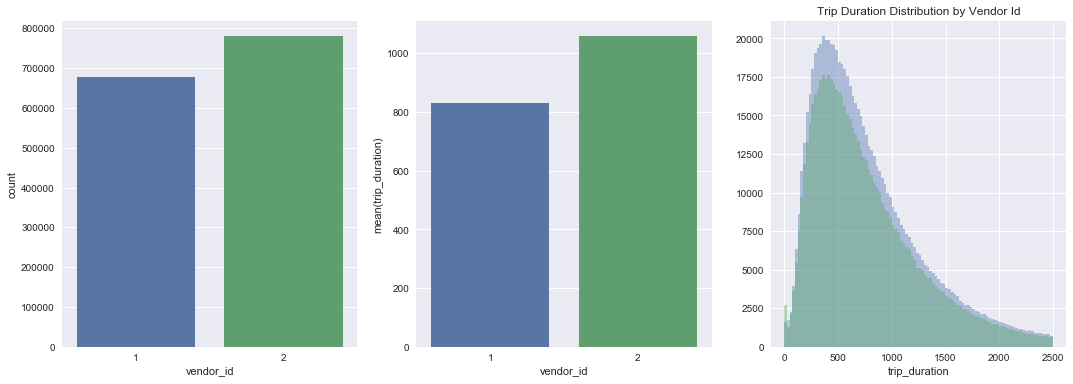

In [236]:
# check distribution of vendor_id
_ = plt.figure(figsize=(18,6))
_ = plt.subplot(131)
_ = sns.countplot(train.vendor_id)

_ = plt.subplot(132)
_ = sns.barplot(x=train.vendor_id, y=train.trip_duration, ci=None)

_ = plt.subplot(133)
_ = plt.title('Trip Duration Distribution by Vendor Id')
_ = sns.distplot(train[(train.trip_duration<2500) & (train.vendor_id==2)].trip_duration, bins=100, kde=False)
_ = sns.distplot(train[(train.trip_duration<2500) & (train.vendor_id==1)].trip_duration, bins=100, kde=False)

# confidence intervals dont overlap so there IS a statistical difference
# import statsmodels.stats.api as sms
# dist2 = train[train.vendor_id==2].trip_duration.values
# dist1 = train[train.vendor_id==1].trip_duration.values
# dist1.mean(), sms.DescrStatsW(dist1).tconfint_mean()
# dist2.mean(), sms.DescrStatsW(dist2).tconfint_mean()

Datetime Range 2016-01-01 00:00:17 -> 2016-06-30 23:59:39


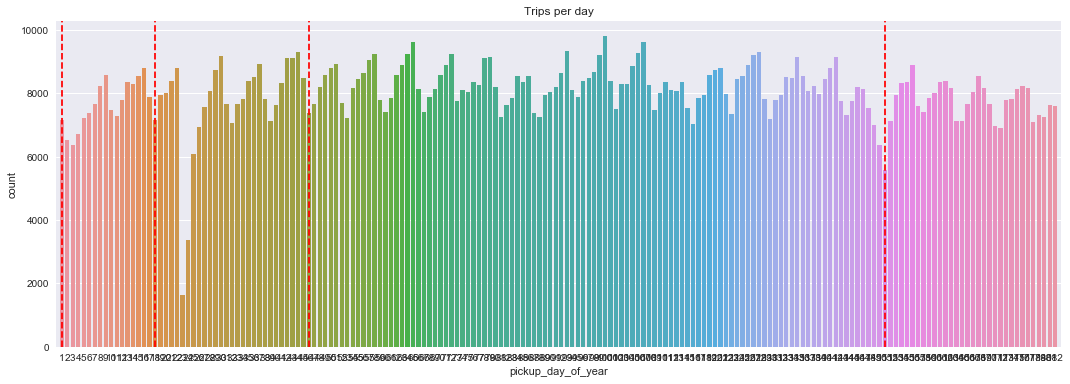

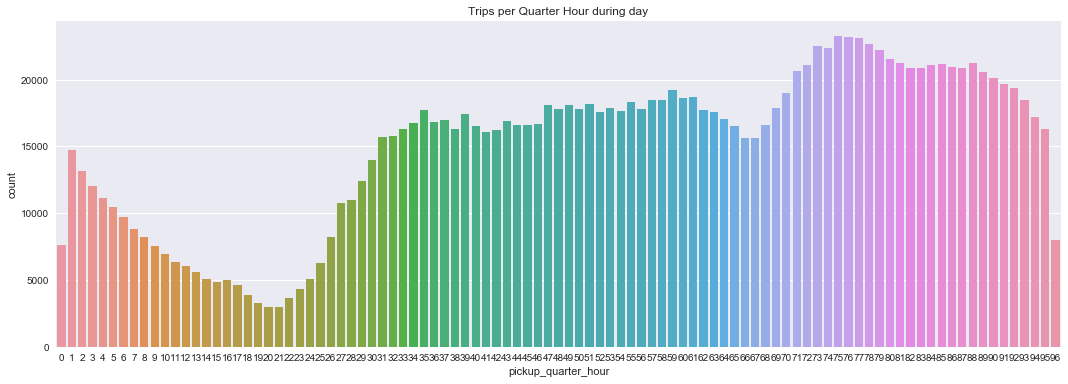

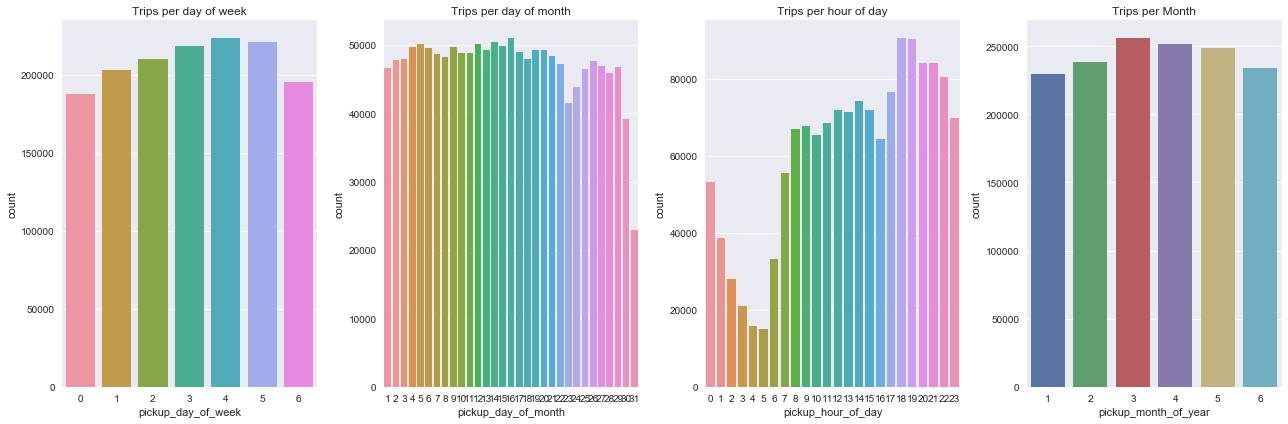

In [237]:
#check number of trips by various time periods
print('Datetime Range', train.pickup_datetime.min(), '->', train.pickup_datetime.max())

_ = plt.figure(figsize=(18,6))
_ = plt.title("Trips per day")
_ = sns.countplot(train.pickup_day_of_year)
_ = plt.xlim(-1,365//2)

for holiday in ny_public_holidays.dt.dayofyear:
    _ = plt.axvline(x=holiday-1, color='r', linestyle='--')
    
_ = plt.figure(figsize=(18,6))
_ = plt.title("Trips per Quarter Hour during day")
_ = sns.countplot(train.pickup_quarter_hour)

_ = plt.figure(figsize=(18,6))
_ = plt.subplot(141)
_ = plt.title("Trips per day of week")
_ = sns.countplot(train.pickup_day_of_week)

_ = plt.subplot(142)
_ = plt.title("Trips per day of month")
_ = sns.countplot(train.pickup_day_of_month)

_ = plt.subplot(143)
_ = plt.title("Trips per hour of day")
_ = sns.countplot(train.pickup_hour_of_day)

_ = plt.subplot(144)
_ = plt.title("Trips per Month")
_ = sns.countplot(train.pickup_month_of_year)

_ = plt.tight_layout()

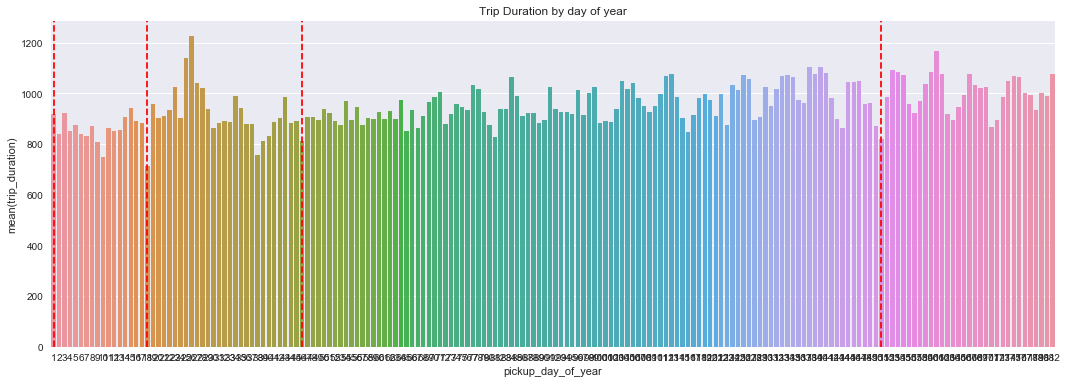

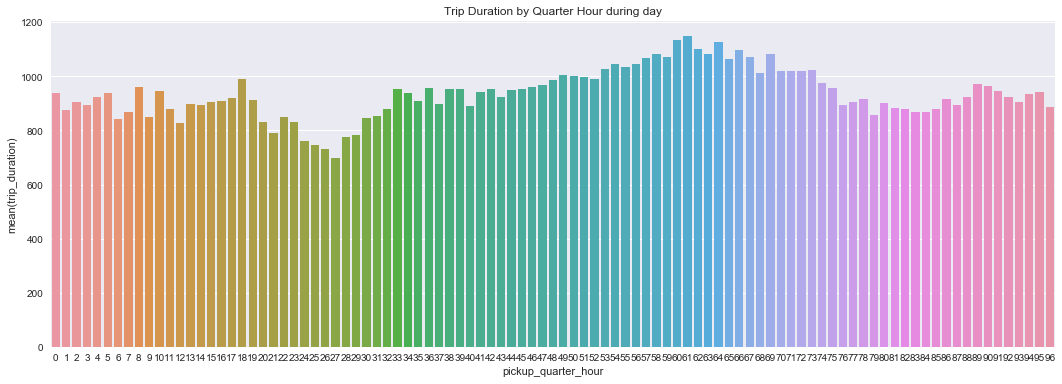

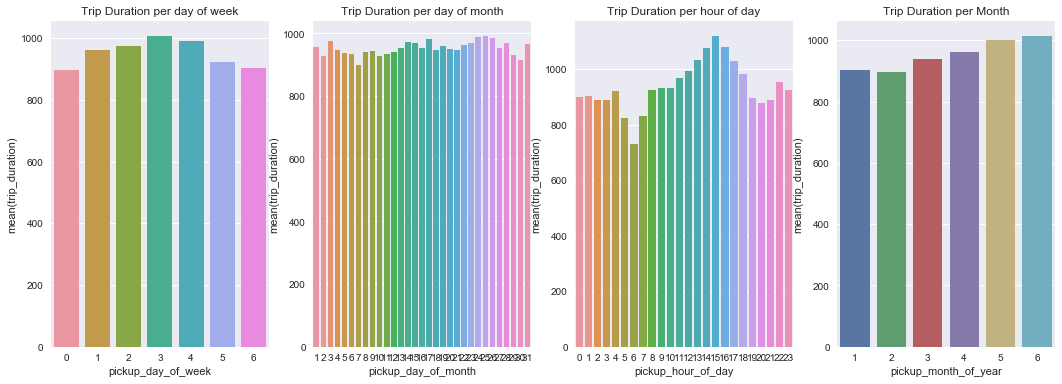

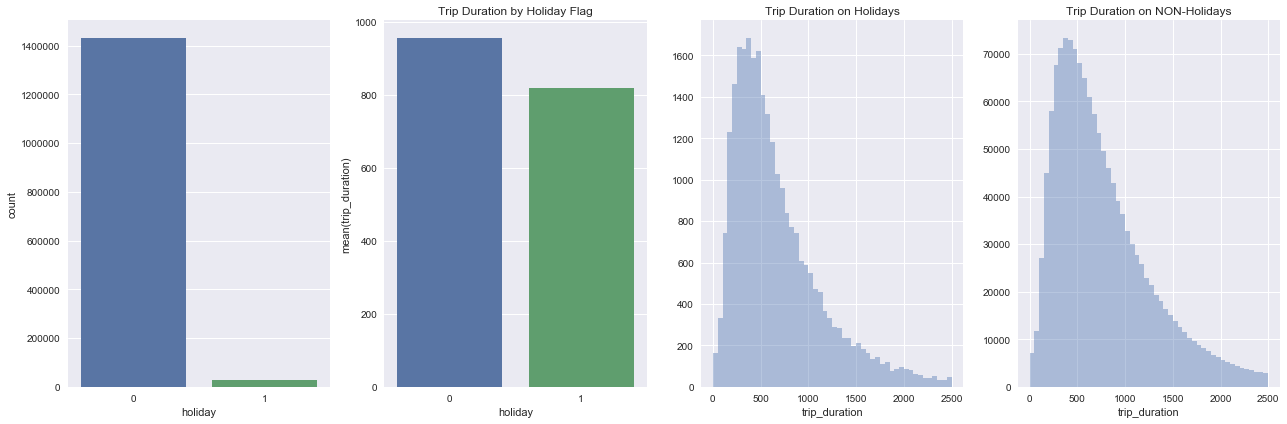

In [238]:
# show trip durations by various time periods
_ = plt.figure(figsize=(18,6))
_ = plt.title("Trip Duration by day of year")
_ = sns.barplot(x=train.pickup_day_of_year, y=train.trip_duration, ci=None)
for holiday in ny_public_holidays.dt.dayofyear:
    _ = plt.axvline(x=holiday-1, color='r', linestyle='--')
    
_ = plt.figure(figsize=(18,6))
_ = plt.title("Trip Duration by Quarter Hour during day")
_ = sns.barplot(x=train.pickup_quarter_hour, y=train.trip_duration, ci=None)

_ = plt.figure(figsize=(18,6))
_ = plt.subplot(141)
_ = plt.title("Trip Duration per day of week")
_ = sns.barplot(x=train.pickup_day_of_week, y=train.trip_duration, ci=None)

_ = plt.subplot(142)
_ = plt.title("Trip Duration per day of month")
_ = sns.barplot(x=train.pickup_day_of_month, y=train.trip_duration, ci=None)

_ = plt.subplot(143)
_ = plt.title("Trip Duration per hour of day")
_ = sns.barplot(x=train.pickup_hour_of_day, y=train.trip_duration, ci=None)

_ = plt.subplot(144)
_ = plt.title("Trip Duration per Month")
_ = sns.barplot(x=train.pickup_month_of_year, y=train.trip_duration, ci=None)

# check distribution of holiday flag
_ = plt.figure(figsize=(18,6))
_ = plt.subplot(141)
_ = sns.countplot(train.holiday)

_ = plt.subplot(142)
_ = plt.title("Trip Duration by Holiday Flag")
_ = sns.barplot(x=train.holiday, y=train.trip_duration, ci=None)

_ = plt.subplot(143)
_ = plt.title('Trip Duration on Holidays')
_ = sns.distplot(train[(train.trip_duration<2500) & (train.holiday)].trip_duration, bins=50, kde=False)
_ = plt.subplot(144)
_ = plt.title('Trip Duration on NON-Holidays')
_ = sns.distplot(train[(train.trip_duration<2500) & ~(train.holiday)].trip_duration, bins=50, kde=False)

_ = plt.tight_layout()

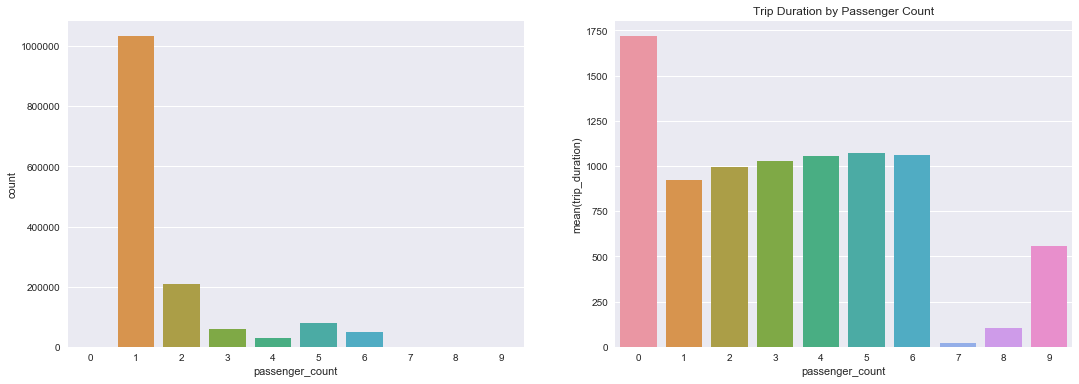

Mean trip duration and confidence intervals for trip duration for each passenger count


(0, 1718.4333333333334, (-1141.8081375960392, 4578.6748042627059))

(1, 922.9584727010257, (917.31867619429613, 928.59826920775527))

(2, 995.71793055245178, (982.02972072384523, 1009.4061403810583))

(3, 1028.2362762121011, (998.45478378980408, 1058.017768634398))

(4, 1053.5297493310802, (1009.4563394841388, 1097.6031591780215))

(5, 1070.2321739575864, (1039.5145211999172, 1100.9498267152555))

(6, 1061.3552231394699, (1022.3929175627042, 1100.3175287162355))

(7, 19.666666666666668, (7.1634477074449006, 32.169885625888433))

/Users/graham/anaconda/lib/python3.6/site-packages/statsmodels/stats/weightstats.py:224: RuntimeWarning: invalid value encountered in double_scalars
  return std / np.sqrt(self.sum_weights - 1)


(8, 104.0, (nan, nan))

(9, 560.0, (nan, nan))

In [239]:
# check distribution of passenger_count
#train.passenger_count.value_counts()

_ = plt.figure(figsize=(18,6))
_ = plt.subplot(121)
_ = sns.countplot(train.passenger_count)

_ = plt.subplot(122)
_ = plt.title("Trip Duration by Passenger Count")
_ = sns.barplot(x=train.passenger_count, y=train.trip_duration, ci=None)
_ = plt.show()

# confidence intervals dont overlap so there IS a statistical difference
import statsmodels.stats.api as sms
print('Mean trip duration and confidence intervals for trip duration for each passenger count')
for count in sorted(train.passenger_count.unique()):
    distribution = train[train.passenger_count==count].trip_duration.values
    count, distribution.mean(), sms.DescrStatsW(distribution).tconfint_mean()

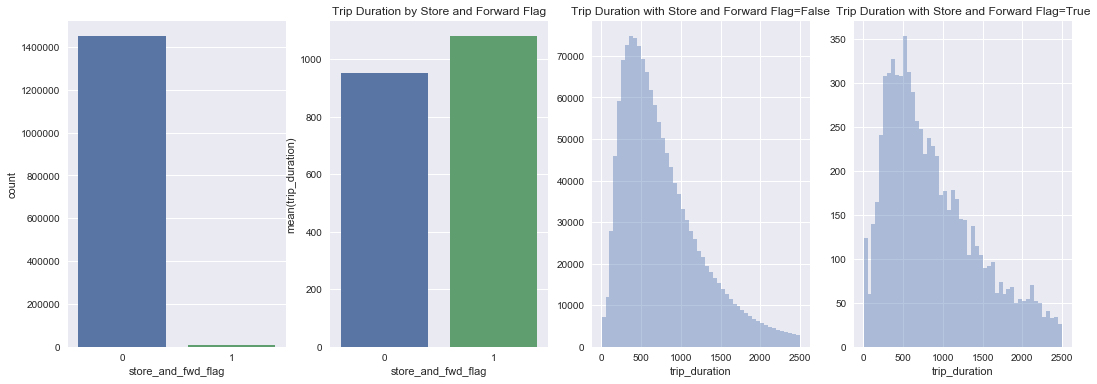

In [240]:
# check distribution of store and forward flag
#train.store_and_fwd_flag.value_counts()

_ = plt.figure(figsize=(18,6))
_ = plt.subplot(141)
_ = sns.countplot(train.store_and_fwd_flag)

_ = plt.subplot(142)
_ = plt.title("Trip Duration by Store and Forward Flag")
_ = sns.barplot(x=train.store_and_fwd_flag, y=train.trip_duration, ci=None)

_ = plt.subplot(143)
_ = plt.title("Trip Duration with Store and Forward Flag=False")
_ = sns.distplot(train[(train.trip_duration<2500) & (train.store_and_fwd_flag==0)].trip_duration, bins=50, kde=False)
_ = plt.subplot(144)
_ = plt.title("Trip Duration with Store and Forward Flag=True")
_ = sns.distplot(train[(train.trip_duration<2500) & (train.store_and_fwd_flag==1)].trip_duration, bins=50, kde=False)

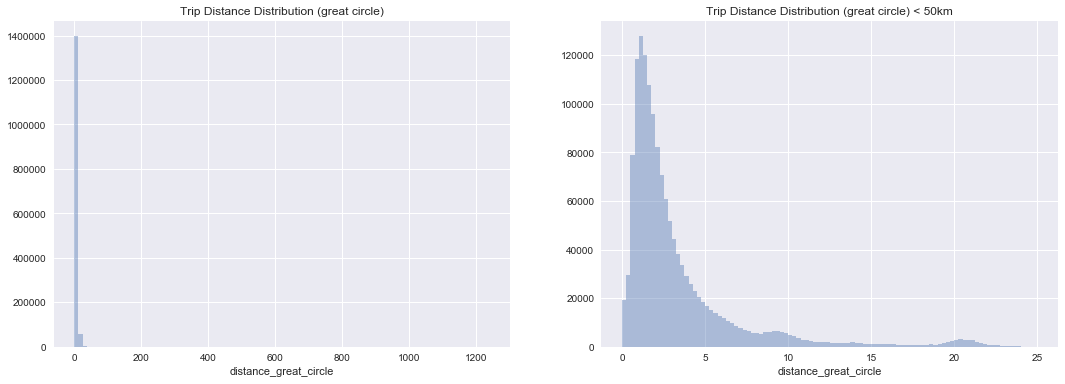

In [241]:
# check distribution of distance (great circle) - maybe should model on log(dist) to get a more normal distribution

_ = plt.figure(figsize=(18,6))
_ = plt.subplot(121)
_ = plt.title("Trip Distance Distribution (great circle)")
_ = sns.distplot(train.distance_great_circle, bins=100, kde=False)

_ = plt.subplot(122)
_ = plt.title("Trip Distance Distribution (great circle) < 50km")
_ = sns.distplot(train[train.distance_great_circle<25].distance_great_circle,bins=100, kde=False)

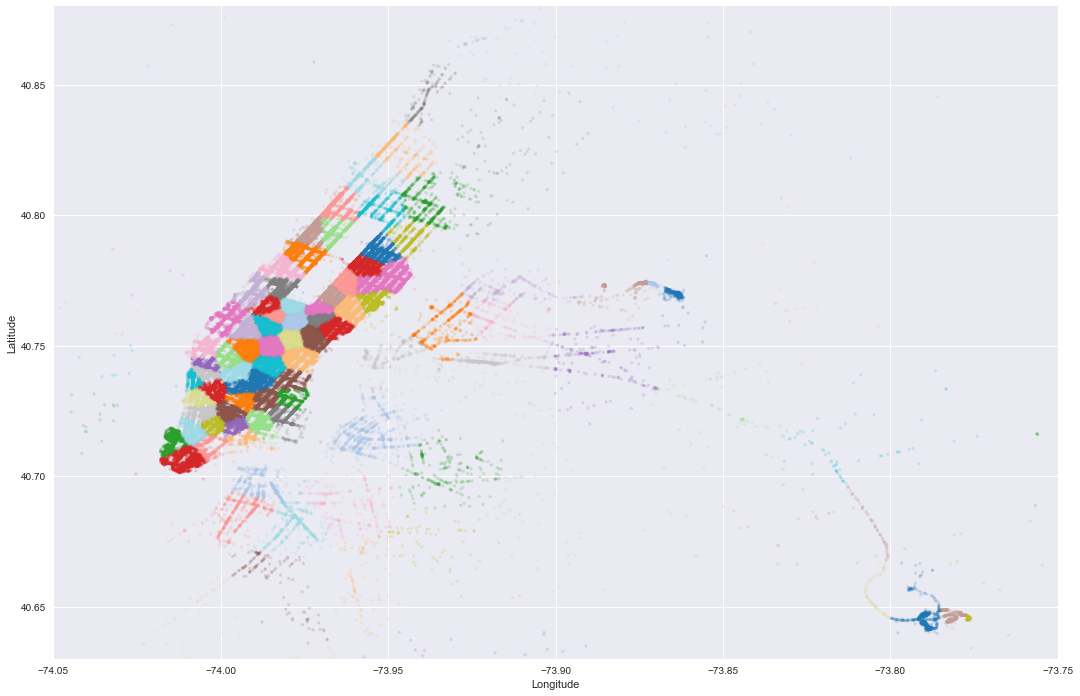

In [242]:
# check clustering is working ok
N= 200000 # filter a subset for faster plotting
_ = plt.figure(figsize=(18,12))
_ = plt.scatter(train.pickup_longitude.values[:N], train.pickup_latitude.values[:N], s=10, lw=0,
           c=train.pickup_cluster[:N].values, cmap='tab20', alpha=0.2)
_ = plt.xlim((-74.05, -73.75))
_ = plt.ylim((40.63, 40.88))
_ = plt.xlabel('Longitude')
_ = plt.ylabel('Latitude')

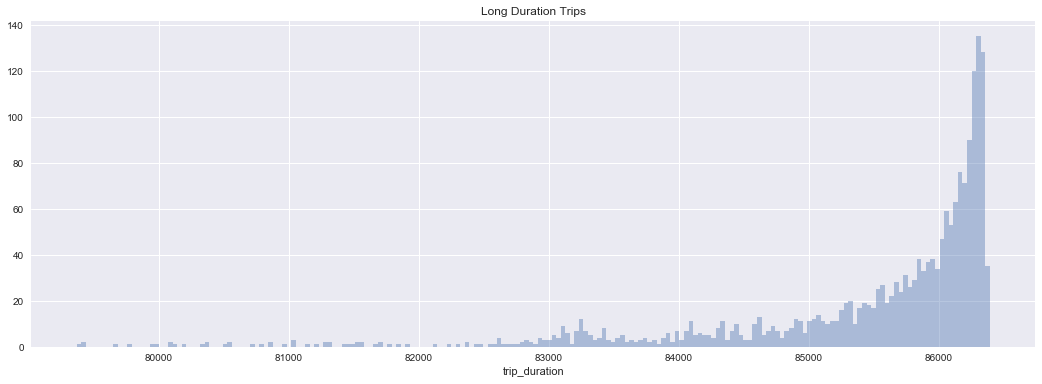

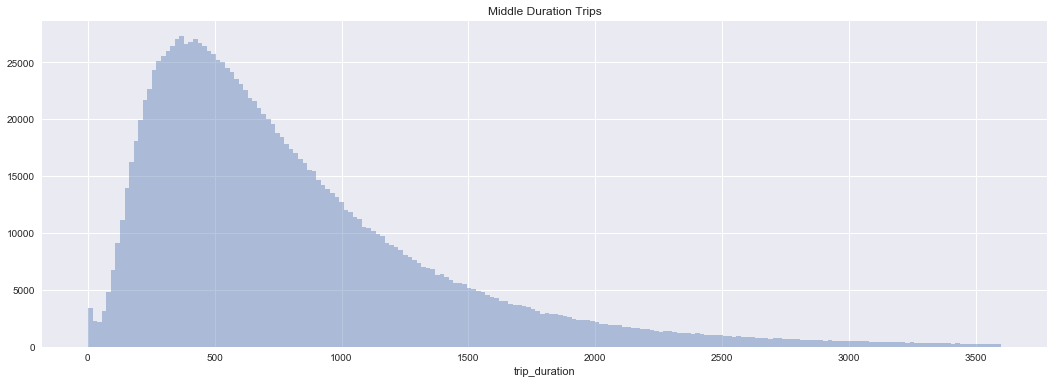

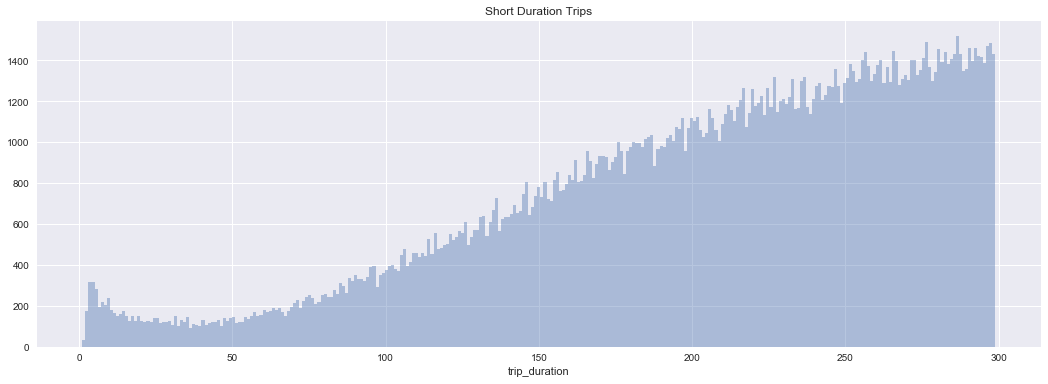

In [243]:
# investigate overall trip duration distribution
_ = plt.figure(figsize=(18,6))
_ = plt.title('Long Duration Trips')
_ = sns.distplot(train.trip_duration[train.trip_duration> 22*60*60], bins=200, kde=False)

_ = plt.figure(figsize=(18,6))
_ = plt.title('Middle Duration Trips')
_ = sns.distplot(train.trip_duration[train.trip_duration< 60*60], bins=200, kde=False)

_ = plt.figure(figsize=(18,6))
_ = plt.title('Short Duration Trips')
_ = sns.distplot(train.trip_duration[train.trip_duration< 5*60], bins=299, kde=False)

CPU times: user 49.2 s, sys: 397 ms, total: 49.6 s
Wall time: 49.8 s


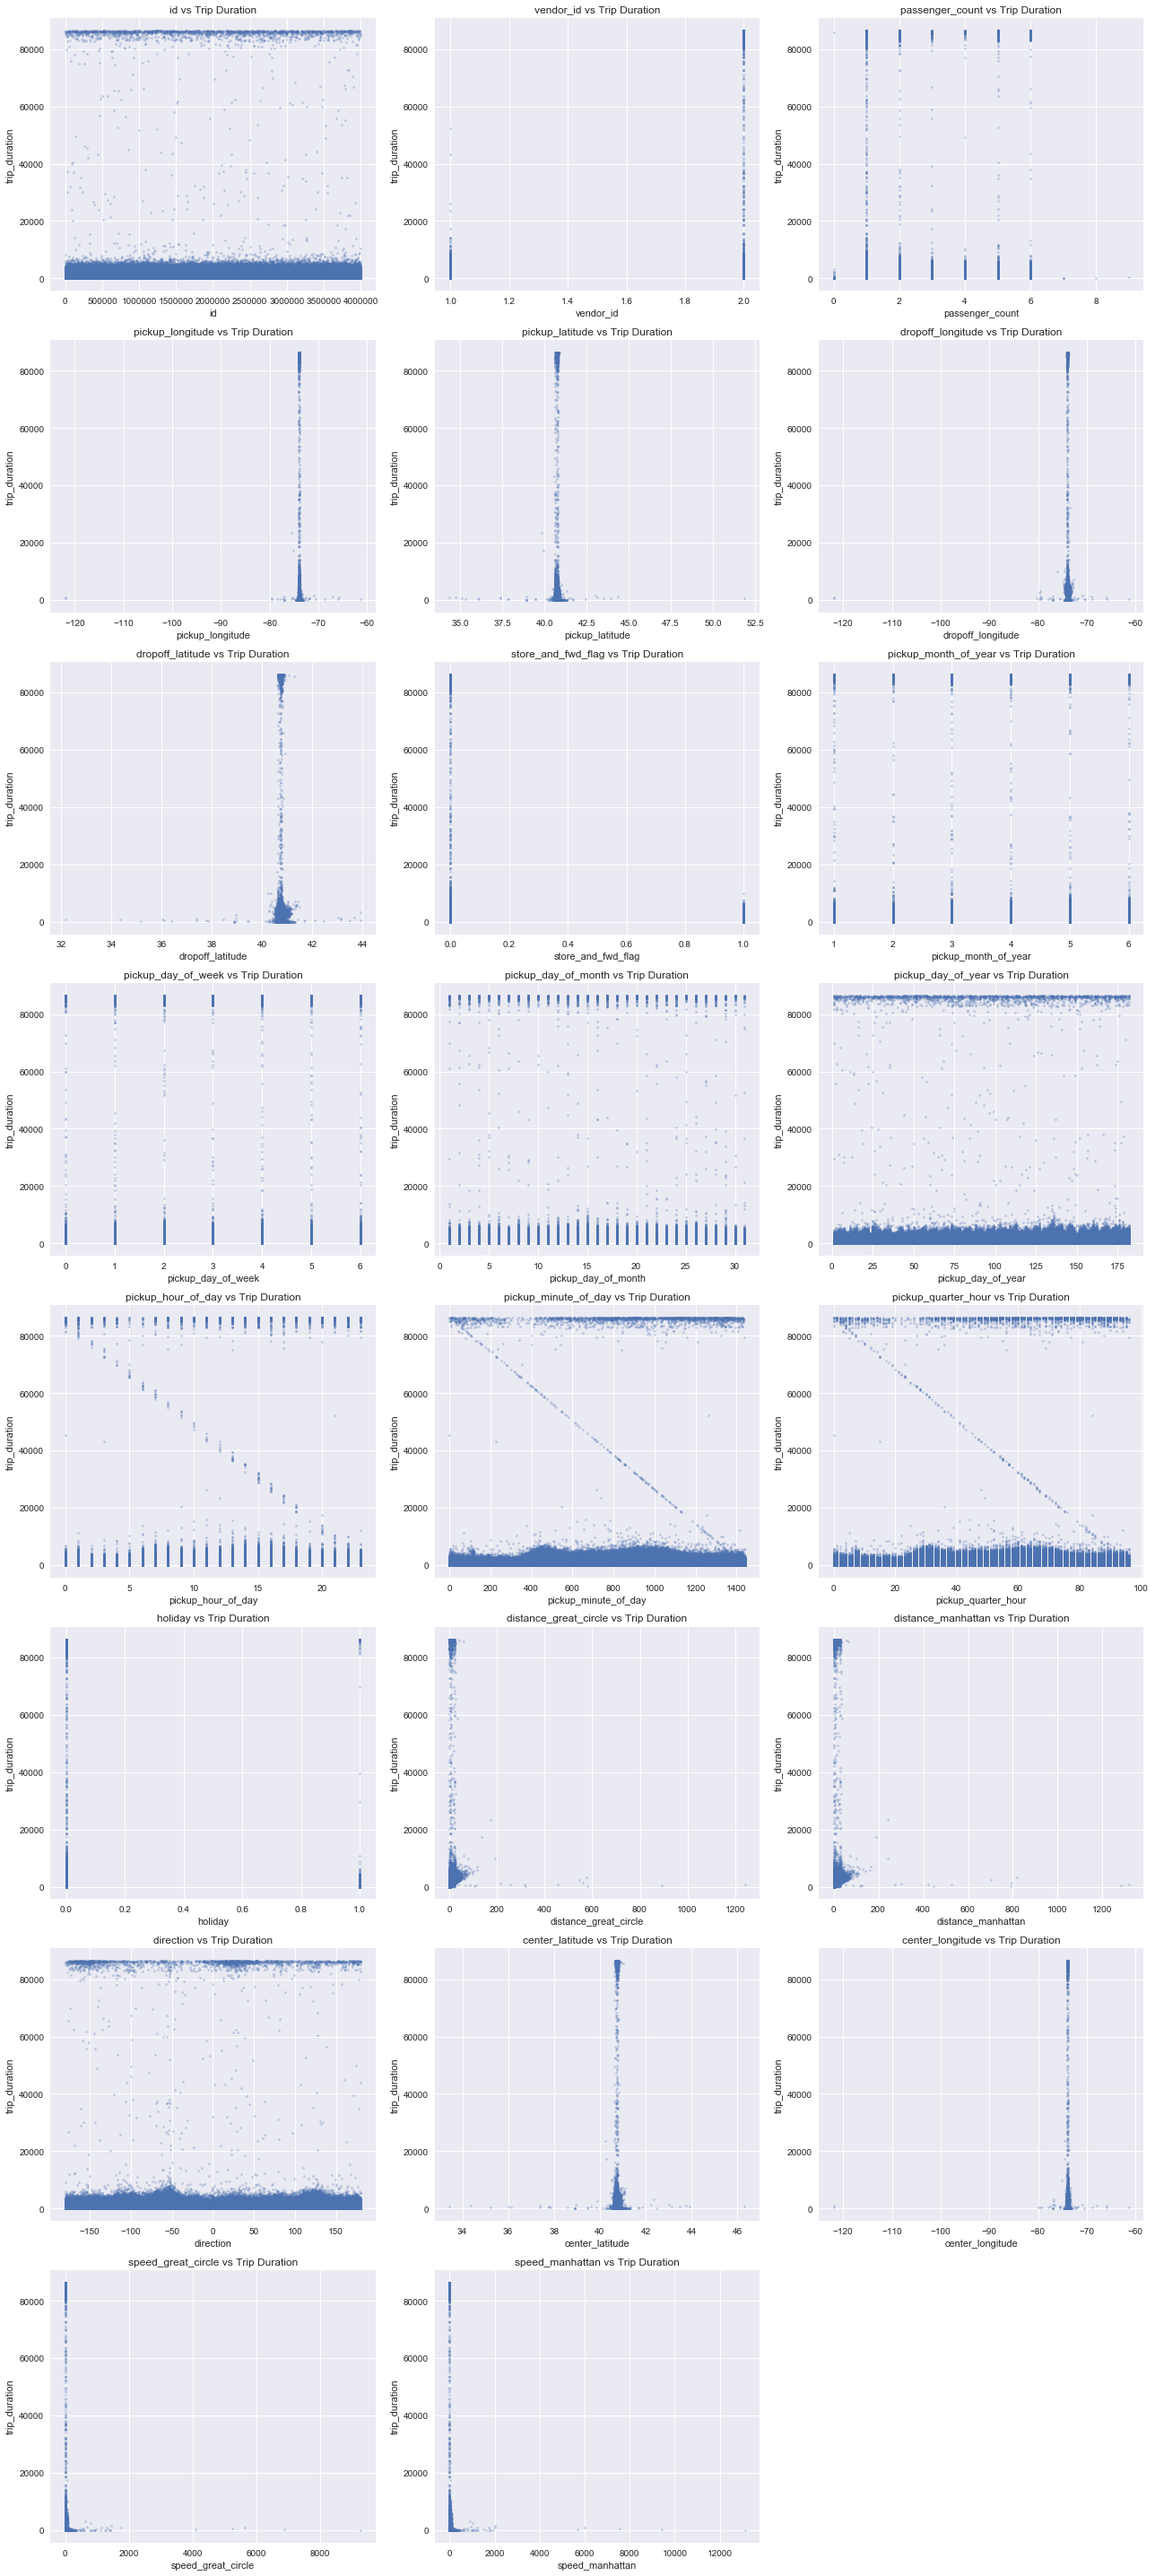

In [12]:
%%time
# scatter plot of all fields vs trip_duration - takes a LONG time to run

_ = plt.figure(figsize=(18,40))
fields = [field for field in train.columns 
          if train[field].dtype in [np.int64, np.float64] and field not in ['trip_duration','log_trip_duration']]

for count, field in enumerate(fields):
        _ = plt.subplot(len(fields) // 3 + 1, 3, count+1)
        _ = plt.scatter(x=field, y='trip_duration', data=train, s=5, alpha=0.3, marker='o')
        _ = plt.title(field + ' vs Trip Duration')
        _ = plt.xlabel(field)
        _ = plt.ylabel('trip_duration')
plt.tight_layout()

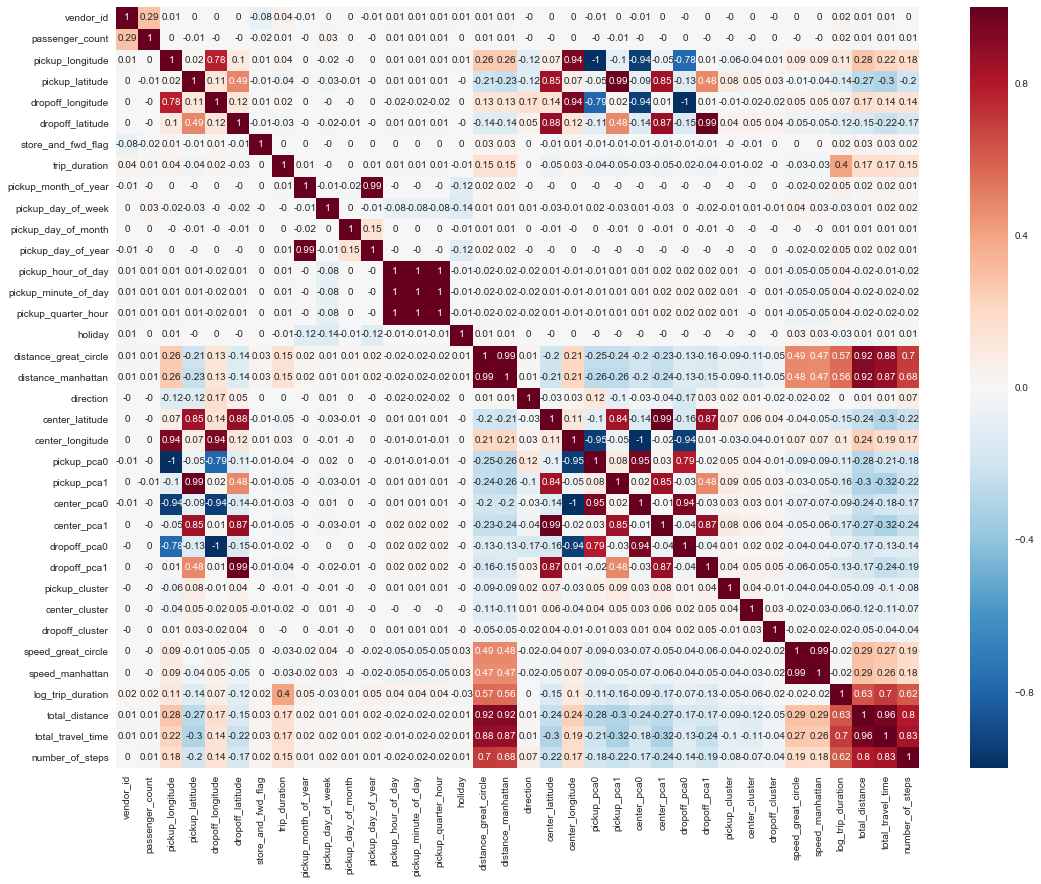

In [99]:
# check for (linear) correlations between predictor variables and trip_duration
corr = np.round(train.corr(),2)
_ = plt.figure(figsize=(18,14))
_ = sns.heatmap(corr, xticklabels=corr.columns.values, yticklabels=corr.columns.values, annot=True)

## Prepare Data for modelling

In [136]:
# create data for model training/validation and filter to optimise training
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

train = train_backup.copy() # refresh train from backup (to allow repeated filtering below)
train_y = train.log_trip_duration

drop_rows  = np.concatenate([
    train[train.trip_duration > 4000].index.values, # remove long duration trips to improve XGBoost
    ]) 

drop_columns = ['id', 'pickup_datetime', 'dropoff_datetime', 'trip_duration', 
                'log_trip_duration', 'speed_great_circle', 'speed_manhattan']
feature_names = [feature for feature in train.columns if feature not in drop_columns]

Xtrain, Xvalid, ytrain, yvalid = train_test_split(train[feature_names], train_y, test_size=0.1, random_state=2)
Xtest = test[feature_names]

# filter training set only (should NOT filter validation set)
print('Before Xtrain= {0}, Xvalid= {1}, Xtest= {2}'.format(Xtrain.shape, Xvalid.shape, Xtest.shape))

# filtering not required for XGBoost
# Xtrain = Xtrain[(Xtrain.trip_duration < 24 * 60 * 60) &  # get rid of 'noisy' long trips that skew predictions
#              (~Xtrain.passenger_count.isin([0,7,8,9])) &
#              (Xtrain.pickup_latitude > 40)    & (Xtrain.pickup_latitude < 41.5) &
#               (Xtrain.pickup_longitude > -75) & (Xtrain.pickup_longitude < -73) &
#              (Xtrain.distance_great_circle < 99) &
#              ~((Xtrain.speed_great_circle > 60) & (Xtrain.trip_duration < 60)) &
#              (Xtrain.speed_great_circle < 120)].index

Xtrain = Xtrain.drop(drop_rows, errors='ignore')
ytrain = ytrain.drop(drop_rows, errors='ignore')
print('After  Xtrain= {0}, Xvalid= {1}, Xtest= {2}'.format(Xtrain.shape, Xvalid.shape, Xtest.shape))

# scaling doesnt seem to do much for Ridge, but it does make coefs represent importance
# scaler = StandardScaler()
# _ = scaler.fit(train[feature_names])
# Xtrain_sc = scaler.transform(Xtrain)
# Xvalid_sc = scaler.transform(Xvalid)
# Xtest_sc  = scaler.transform(Xtest)

Before Xtrain= (1312776, 32), Xvalid= (145864, 32), Xtest= (625134, 32)
After  Xtrain= (1305276, 32), Xvalid= (145864, 32), Xtest= (625134, 32)


## XGBoost Model and Submission Generation
Performs really well (as usual)

In [151]:
%%time
import xgboost as xgb
from sklearn.metrics import mean_squared_error

dtrain = xgb.DMatrix(Xtrain, label=ytrain)
dvalid = xgb.DMatrix(Xvalid, label=yvalid)
watchlist = [(dtrain, 'train'), (dvalid, 'valid')]

# manually optimised, initially from kaggle
params_m = {'min_child_weight': 28, 'eta': 0.17, 'colsample_bytree': 0.54, 'max_depth': 16,
          'subsample': 0.95, 'lambda': 1, 'nthread': 8, 'booster' : 'gbtree', 'silent': 1,
          'eval_metric': 'rmse', 'objective': 'reg:linear'}

# from scikit-optimize [133, 0.17936020611338641, 0.70459161599199072, 64, 1.0, 24.2701922969149, 0]
params_s = {'min_child_weight': 133, 'eta': 0.17936, 'colsample_bytree': 0.70459, 'max_depth': 64,
          'subsample': 1.0, 'lambda': 24.27, 'gamma': 0, 'nthread': 8, 'booster' : 'gbtree', 'silent': 1,
          'eval_metric': 'rmse', 'objective': 'reg:linear'}

XGmodel = xgb.train(params=params_s, dtrain=dtrain, num_boost_round=800, evals=watchlist, early_stopping_rounds=50, 
                    maximize=False, verbose_eval=10)

XGtrain_preds = XGmodel.predict(dtrain)
XGvalid_preds = XGmodel.predict(dvalid)
print('\nTrain  RMSE =', round(np.sqrt(mean_squared_error(ytrain, XGtrain_preds)),6))
print('Validn RMSE =', round(np.sqrt(mean_squared_error(yvalid, XGvalid_preds)),6))

[0]	train-rmse:4.93095	valid-rmse:4.94847
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[10]	train-rmse:0.777307	valid-rmse:0.808111
[20]	train-rmse:0.338761	valid-rmse:0.395887
[30]	train-rmse:0.297289	valid-rmse:0.37005
[40]	train-rmse:0.278907	valid-rmse:0.36514
[50]	train-rmse:0.265811	valid-rmse:0.363451
[60]	train-rmse:0.259875	valid-rmse:0.363167
[70]	train-rmse:0.256904	valid-rmse:0.363079
[80]	train-rmse:0.254767	valid-rmse:0.363147
[90]	train-rmse:0.25158	valid-rmse:0.363215
[100]	train-rmse:0.247844	valid-rmse:0.36303
[110]	train-rmse:0.245152	valid-rmse:0.363089
[120]	train-rmse:0.243569	valid-rmse:0.363155
[130]	train-rmse:0.240284	valid-rmse:0.362881
[140]	train-rmse:0.238333	valid-rmse:0.36295
[150]	train-rmse:0.237087	valid-rmse:0.36314
[160]	train-rmse:0.235969	valid-rmse:0.363181
[170]	train-rmse:0.23457	valid-rmse:0.363267
[180]	train-rmse:0.232045	valid-rmse:0.363283
S

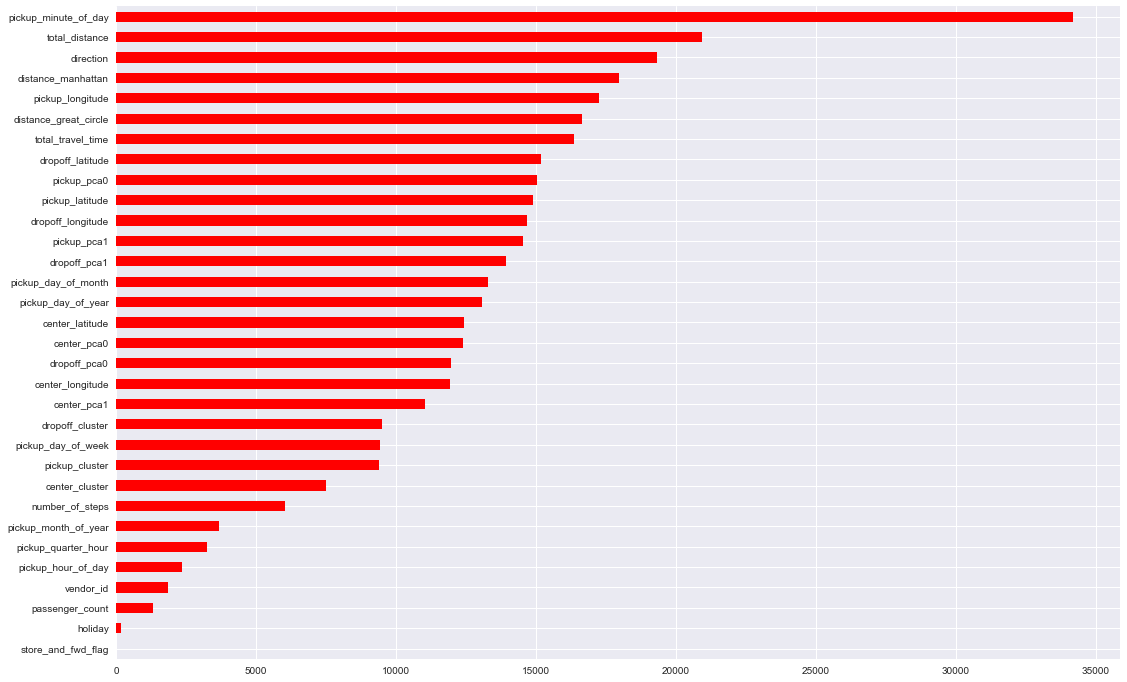

In [152]:
feature_importance = pd.Series(index = Xtrain.columns, data = XGmodel.get_fscore())
_ = feature_importance.sort_values(ascending=True).head(40).plot(kind='barh', color="r", figsize = (18,12))

In [153]:
dtest = xgb.DMatrix(Xtest)
XGlog_test_preds = XGmodel.predict(dtest)
XGtest_preds = np.exp(XGlog_test_preds) - 1
XGpreds = pd.DataFrame({'id': test_id, 'trip_duration': XGtest_preds})
XGpreds.to_csv('XG_submission.csv.gz', index=False, compression='gzip')

## XGBoost model hyperparameter search - scikit optimise

In [141]:
# create a cut down training set to reduce training time
sample_size = 200000
print('Total training size',len(Xtrain))
print('Train sample size =', sample_size)
train_samples = np.random.choice(Xtrain.index, size=sample_size)
Xtrain_small = Xtrain.loc[train_samples]
ytrain_small = ytrain.loc[train_samples]

Total training size 1305276
Train sample size = 200000


In [146]:
from skopt import gp_minimize
from sklearn.metrics import mean_squared_error
import xgboost as xgb

def objective(values): 
    params = {'min_child_weight': values[0], 
              'eta': values[1], 
              'colsample_bytree': values[2], 
              'max_depth': values[3],
              'subsample': values[4], 
              'lambda': values[5], 
              'gamma': values[6],
              'nthread': 8, 'booster' : 'gbtree', 'silent': 1, 'eval_metric': 'rmse', 'objective': 'reg:linear'}
    print('\nNext set of params.....',params)
    XGmodel = xgb.train(params=params, dtrain=dtrain_opt, num_boost_round=40, evals=watchlist, early_stopping_rounds=50, 
                    maximize=False, verbose_eval=10)

    XGvalid_preds = XGmodel.predict(dvalid)
    return np.sqrt(mean_squared_error(yvalid, XGvalid_preds))

In [147]:
%%time
# Bayesian optimisation using Gaussian processes- calls objective function n_calls times
space = [(10, 300),    # min_child_weight
         (0.1, 0.3),   # eta
         (0.4, 1),     # colsample_bytree
         (5, 300),     # max_depth
         (0.8, 1),     # subsample
         (0.1, 90),    # lambda
         (0, 2),       # gamma
        ]

dtrain_opt = xgb.DMatrix(Xtrain_small, label=ytrain_small) # use cutdown training set
result = gp_minimize(objective, space, n_calls=800, random_state=0, verbose=True)

Iteration No: 1 started. Evaluating function at random point.

Next set of params..... {'min_child_weight': 169, 'eta': 0.24303787327448392, 'colsample_bytree': 0.76165802564298635, 'max_depth': 111, 'subsample': 0.88473095986778094, 'lambda': 58.165880764692403, 'gamma': 1, 'nthread': 8, 'booster': 'gbtree', 'silent': 1, 'eval_metric': 'rmse', 'objective': 'reg:linear'}
[0]	train-rmse:4.55617	valid-rmse:4.57455
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[10]	train-rmse:0.479773	valid-rmse:0.51989
[20]	train-rmse:0.348796	valid-rmse:0.394411
[30]	train-rmse:0.338764	valid-rmse:0.385468
[39]	train-rmse:0.334927	valid-rmse:0.382512
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 11.1970
Function value obtained: 0.3825
Current minimum: 0.3825
Iteration No: 2 started. Evaluating function at random point.

Next set of params..... {'min_child_weight': 269, 'eta': 0.292732

[0]	train-rmse:5.17256	valid-rmse:5.19074
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[10]	train-rmse:1.23374	valid-rmse:1.25914
[20]	train-rmse:0.463937	valid-rmse:0.506017
[30]	train-rmse:0.358759	valid-rmse:0.406712
[39]	train-rmse:0.341001	valid-rmse:0.390742
Iteration No: 10 ended. Evaluation done at random point.
Time taken: 7.7456
Function value obtained: 0.3907
Current minimum: 0.3814
Iteration No: 11 started. Searching for the next optimal point.

Next set of params..... {'min_child_weight': 300, 'eta': 0.29999999999999999, 'colsample_bytree': 1.0, 'max_depth': 5, 'subsample': 1.0, 'lambda': 0.10000000000000001, 'gamma': 0, 'nthread': 8, 'booster': 'gbtree', 'silent': 1, 'eval_metric': 'rmse', 'objective': 'reg:linear'}
[0]	train-rmse:4.21192	valid-rmse:4.22956
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse has

[0]	train-rmse:4.90625	valid-rmse:4.92378
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[10]	train-rmse:0.737612	valid-rmse:0.771185
[20]	train-rmse:0.353413	valid-rmse:0.406764
[30]	train-rmse:0.338472	valid-rmse:0.392655
[39]	train-rmse:0.336196	valid-rmse:0.390659
Iteration No: 20 ended. Search finished for the next optimal point.
Time taken: 29.6053
Function value obtained: 0.3907
Current minimum: 0.3814
Iteration No: 21 started. Searching for the next optimal point.

Next set of params..... {'min_child_weight': 10, 'eta': 0.29999999999999999, 'colsample_bytree': 1.0, 'max_depth': 62, 'subsample': 0.80000000000000004, 'lambda': 0.10000000000000001, 'gamma': 0, 'nthread': 8, 'booster': 'gbtree', 'silent': 1, 'eval_metric': 'rmse', 'objective': 'reg:linear'}
[0]	train-rmse:4.20997	valid-rmse:4.22739
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

W

Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[10]	train-rmse:0.417219	valid-rmse:0.459257
[20]	train-rmse:0.375422	valid-rmse:0.417948
[30]	train-rmse:0.364118	valid-rmse:0.407103
[39]	train-rmse:0.358552	valid-rmse:0.401991
Iteration No: 30 ended. Search finished for the next optimal point.
Time taken: 2.7177
Function value obtained: 0.4020
Current minimum: 0.3814
Iteration No: 31 started. Searching for the next optimal point.

Next set of params..... {'min_child_weight': 248, 'eta': 0.24310915105599318, 'colsample_bytree': 1.0, 'max_depth': 200, 'subsample': 1.0, 'lambda': 90.0, 'gamma': 0, 'nthread': 8, 'booster': 'gbtree', 'silent': 1, 'eval_metric': 'rmse', 'objective': 'reg:linear'}
[0]	train-rmse:4.55617	valid-rmse:4.57441
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[10]	train-rmse

[0]	train-rmse:4.58298	valid-rmse:4.60121
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[10]	train-rmse:0.495166	valid-rmse:0.53583
[20]	train-rmse:0.349209	valid-rmse:0.397375
[30]	train-rmse:0.3376	valid-rmse:0.386874
[39]	train-rmse:0.333818	valid-rmse:0.384335
Iteration No: 40 ended. Search finished for the next optimal point.
Time taken: 18.0331
Function value obtained: 0.3843
Current minimum: 0.3814
Iteration No: 41 started. Searching for the next optimal point.

Next set of params..... {'min_child_weight': 199, 'eta': 0.25794482641680794, 'colsample_bytree': 0.42167304327872585, 'max_depth': 197, 'subsample': 0.89068476094339843, 'lambda': 88.214861526529546, 'gamma': 1, 'nthread': 8, 'booster': 'gbtree', 'silent': 1, 'eval_metric': 'rmse', 'objective': 'reg:linear'}
[0]	train-rmse:4.4688	valid-rmse:4.48722
Multiple eval metrics have been passed: 'valid-rmse' will be used for early

[39]	train-rmse:0.338553	valid-rmse:0.385862
Iteration No: 49 ended. Search finished for the next optimal point.
Time taken: 6.3262
Function value obtained: 0.3859
Current minimum: 0.3814
Iteration No: 50 started. Searching for the next optimal point.

Next set of params..... {'min_child_weight': 35, 'eta': 0.10404879696874483, 'colsample_bytree': 0.74108161367469361, 'max_depth': 191, 'subsample': 0.96296418543551854, 'lambda': 0.48023613107988539, 'gamma': 0, 'nthread': 8, 'booster': 'gbtree', 'silent': 1, 'eval_metric': 'rmse', 'objective': 'reg:linear'}
[0]	train-rmse:5.37948	valid-rmse:5.39726
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[10]	train-rmse:1.82871	valid-rmse:1.84895
[20]	train-rmse:0.692901	valid-rmse:0.726973
[30]	train-rmse:0.38936	valid-rmse:0.440853
[39]	train-rmse:0.335144	valid-rmse:0.39279
Iteration No: 50 ended. Search finished for the next optimal point.
Time 

[0]	train-rmse:4.83057	valid-rmse:4.84889
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[10]	train-rmse:0.674172	valid-rmse:0.707345
[20]	train-rmse:0.361955	valid-rmse:0.407524
[30]	train-rmse:0.342483	valid-rmse:0.388999
[39]	train-rmse:0.336886	valid-rmse:0.384511
Iteration No: 59 ended. Search finished for the next optimal point.
Time taken: 9.4615
Function value obtained: 0.3845
Current minimum: 0.3814
Iteration No: 60 started. Searching for the next optimal point.

Next set of params..... {'min_child_weight': 131, 'eta': 0.26698876760386747, 'colsample_bytree': 1.0, 'max_depth': 200, 'subsample': 1.0, 'lambda': 90.0, 'gamma': 0, 'nthread': 8, 'booster': 'gbtree', 'silent': 1, 'eval_metric': 'rmse', 'objective': 'reg:linear'}
[0]	train-rmse:4.4145	valid-rmse:4.43277
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn

[39]	train-rmse:0.338652	valid-rmse:0.385793
Iteration No: 68 ended. Search finished for the next optimal point.
Time taken: 8.6339
Function value obtained: 0.3858
Current minimum: 0.3814
Iteration No: 69 started. Searching for the next optimal point.

Next set of params..... {'min_child_weight': 300, 'eta': 0.26864124468412676, 'colsample_bytree': 1.0, 'max_depth': 200, 'subsample': 1.0, 'lambda': 42.108060898444357, 'gamma': 0, 'nthread': 8, 'booster': 'gbtree', 'silent': 1, 'eval_metric': 'rmse', 'objective': 'reg:linear'}
[0]	train-rmse:4.40265	valid-rmse:4.42101
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[10]	train-rmse:0.422956	valid-rmse:0.466249
[20]	train-rmse:0.344161	valid-rmse:0.391073
[30]	train-rmse:0.336025	valid-rmse:0.384441
[39]	train-rmse:0.332571	valid-rmse:0.382348
Iteration No: 69 ended. Search finished for the next optimal point.
Time taken: 17.5914
Function valu

Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[10]	train-rmse:0.860472	valid-rmse:0.889873
[20]	train-rmse:0.379155	valid-rmse:0.424692
[30]	train-rmse:0.341582	valid-rmse:0.389446
[39]	train-rmse:0.333655	valid-rmse:0.382688
Iteration No: 78 ended. Search finished for the next optimal point.
Time taken: 9.1680
Function value obtained: 0.3827
Current minimum: 0.3814
Iteration No: 79 started. Searching for the next optimal point.

Next set of params..... {'min_child_weight': 300, 'eta': 0.18599765763665849, 'colsample_bytree': 0.52282356042877143, 'max_depth': 13, 'subsample': 0.84917491770733866, 'lambda': 2.2208360711534105, 'gamma': 0, 'nthread': 8, 'booster': 'gbtree', 'silent': 1, 'eval_metric': 'rmse', 'objective': 'reg:linear'}
[0]	train-rmse:4.89151	valid-rmse:4.90928
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse 

[0]	train-rmse:4.40864	valid-rmse:4.42699
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[10]	train-rmse:0.423298	valid-rmse:0.466021
[20]	train-rmse:0.343773	valid-rmse:0.390178
[30]	train-rmse:0.33541	valid-rmse:0.383601
[39]	train-rmse:0.332223	valid-rmse:0.381679
Iteration No: 88 ended. Search finished for the next optimal point.
Time taken: 16.3545
Function value obtained: 0.3817
Current minimum: 0.3813
Iteration No: 89 started. Searching for the next optimal point.

Next set of params..... {'min_child_weight': 156, 'eta': 0.21864774538708331, 'colsample_bytree': 0.52792432789585531, 'max_depth': 96, 'subsample': 0.83048843229568081, 'lambda': 89.633847346908325, 'gamma': 0, 'nthread': 8, 'booster': 'gbtree', 'silent': 1, 'eval_metric': 'rmse', 'objective': 'reg:linear'}
[0]	train-rmse:4.70204	valid-rmse:4.72037
Multiple eval metrics have been passed: 'valid-rmse' will be used for ear

Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[10]	train-rmse:0.447959	valid-rmse:0.489755
[20]	train-rmse:0.351268	valid-rmse:0.397061
[30]	train-rmse:0.340187	valid-rmse:0.386722
[39]	train-rmse:0.335597	valid-rmse:0.383277
Iteration No: 98 ended. Search finished for the next optimal point.
Time taken: 11.7797
Function value obtained: 0.3833
Current minimum: 0.3813
Iteration No: 99 started. Searching for the next optimal point.

Next set of params..... {'min_child_weight': 202, 'eta': 0.29803438405591132, 'colsample_bytree': 0.77725806223062732, 'max_depth': 130, 'subsample': 0.99862902245174467, 'lambda': 49.107777911354184, 'gamma': 0, 'nthread': 8, 'booster': 'gbtree', 'silent': 1, 'eval_metric': 'rmse', 'objective': 'reg:linear'}
[0]	train-rmse:4.22908	valid-rmse:4.24769
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rms

[30]	train-rmse:0.333388	valid-rmse:0.382771
[39]	train-rmse:0.331217	valid-rmse:0.381959
Iteration No: 107 ended. Search finished for the next optimal point.
Time taken: 20.2209
Function value obtained: 0.3820
Current minimum: 0.3813
Iteration No: 108 started. Searching for the next optimal point.

Next set of params..... {'min_child_weight': 300, 'eta': 0.25557676364935644, 'colsample_bytree': 1.0, 'max_depth': 159, 'subsample': 1.0, 'lambda': 34.839203482049264, 'gamma': 0, 'nthread': 8, 'booster': 'gbtree', 'silent': 1, 'eval_metric': 'rmse', 'objective': 'reg:linear'}
[0]	train-rmse:4.47991	valid-rmse:4.49824
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[10]	train-rmse:0.444547	valid-rmse:0.486466
[20]	train-rmse:0.344836	valid-rmse:0.391152
[30]	train-rmse:0.33573	valid-rmse:0.383645
[39]	train-rmse:0.332818	valid-rmse:0.381891
Iteration No: 108 ended. Search finished for the next 

Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[10]	train-rmse:0.406154	valid-rmse:0.449633
[20]	train-rmse:0.349722	valid-rmse:0.395749
[30]	train-rmse:0.339433	valid-rmse:0.38698
[39]	train-rmse:0.335072	valid-rmse:0.383644
Iteration No: 117 ended. Search finished for the next optimal point.
Time taken: 8.7438
Function value obtained: 0.3836
Current minimum: 0.3813
Iteration No: 118 started. Searching for the next optimal point.

Next set of params..... {'min_child_weight': 162, 'eta': 0.29999999999999999, 'colsample_bytree': 1.0, 'max_depth': 153, 'subsample': 1.0, 'lambda': 90.0, 'gamma': 0, 'nthread': 8, 'booster': 'gbtree', 'silent': 1, 'eval_metric': 'rmse', 'objective': 'reg:linear'}
[0]	train-rmse:4.21877	valid-rmse:4.23712
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[10]	train-rms

Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[10]	train-rmse:0.762746	valid-rmse:0.794188
[20]	train-rmse:0.372167	valid-rmse:0.418083
[30]	train-rmse:0.341431	valid-rmse:0.389557
[39]	train-rmse:0.333669	valid-rmse:0.383601
Iteration No: 127 ended. Search finished for the next optimal point.
Time taken: 7.4662
Function value obtained: 0.3836
Current minimum: 0.3813
Iteration No: 128 started. Searching for the next optimal point.

Next set of params..... {'min_child_weight': 13, 'eta': 0.16438989669859622, 'colsample_bytree': 0.98162593443777513, 'max_depth': 196, 'subsample': 0.98643754869191547, 'lambda': 81.060772217724463, 'gamma': 0, 'nthread': 8, 'booster': 'gbtree', 'silent': 1, 'eval_metric': 'rmse', 'objective': 'reg:linear'}
[0]	train-rmse:5.02322	valid-rmse:5.04134
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rms

[0]	train-rmse:4.52516	valid-rmse:4.54352
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[10]	train-rmse:0.472264	valid-rmse:0.512824
[20]	train-rmse:0.35078	valid-rmse:0.396294
[30]	train-rmse:0.33955	valid-rmse:0.386461
[39]	train-rmse:0.334664	valid-rmse:0.382725
Iteration No: 137 ended. Search finished for the next optimal point.
Time taken: 13.1073
Function value obtained: 0.3827
Current minimum: 0.3813
Iteration No: 138 started. Searching for the next optimal point.

Next set of params..... {'min_child_weight': 172, 'eta': 0.29999999999999999, 'colsample_bytree': 1.0, 'max_depth': 154, 'subsample': 1.0, 'lambda': 90.0, 'gamma': 0, 'nthread': 8, 'booster': 'gbtree', 'silent': 1, 'eval_metric': 'rmse', 'objective': 'reg:linear'}
[0]	train-rmse:4.2188	valid-rmse:4.23716
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse has

Iteration No: 146 ended. Search finished for the next optimal point.
Time taken: 18.4807
Function value obtained: 0.3809
Current minimum: 0.3809
Iteration No: 147 started. Searching for the next optimal point.

Next set of params..... {'min_child_weight': 28, 'eta': 0.12089088679022261, 'colsample_bytree': 0.95670631701970144, 'max_depth': 196, 'subsample': 0.97406277067651881, 'lambda': 0.20391325808058219, 'gamma': 2, 'nthread': 8, 'booster': 'gbtree', 'silent': 1, 'eval_metric': 'rmse', 'objective': 'reg:linear'}
[0]	train-rmse:5.27871	valid-rmse:5.2964
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[10]	train-rmse:1.49761	valid-rmse:1.51959
[20]	train-rmse:0.531178	valid-rmse:0.57079
[30]	train-rmse:0.357973	valid-rmse:0.408533
[39]	train-rmse:0.338151	valid-rmse:0.389772
Iteration No: 147 ended. Search finished for the next optimal point.
Time taken: 20.5927
Function value obtained: 0

[0]	train-rmse:4.4301	valid-rmse:4.44837
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[10]	train-rmse:0.435727	valid-rmse:0.478877
[20]	train-rmse:0.343509	valid-rmse:0.391657
[30]	train-rmse:0.33284	valid-rmse:0.383384
[39]	train-rmse:0.328918	valid-rmse:0.381445
Iteration No: 156 ended. Search finished for the next optimal point.
Time taken: 18.6616
Function value obtained: 0.3814
Current minimum: 0.3808
Iteration No: 157 started. Searching for the next optimal point.

Next set of params..... {'min_child_weight': 15, 'eta': 0.26501061572530538, 'colsample_bytree': 0.50699890636656786, 'max_depth': 195, 'subsample': 0.99125875741466762, 'lambda': 88.345986830106057, 'gamma': 0, 'nthread': 8, 'booster': 'gbtree', 'silent': 1, 'eval_metric': 'rmse', 'objective': 'reg:linear'}
[0]	train-rmse:4.42656	valid-rmse:4.4449
Multiple eval metrics have been passed: 'valid-rmse' will be used for ear

[0]	train-rmse:4.56201	valid-rmse:4.58028
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[10]	train-rmse:0.478295	valid-rmse:0.518301
[20]	train-rmse:0.34806	valid-rmse:0.394412
[30]	train-rmse:0.337985	valid-rmse:0.385368
[39]	train-rmse:0.334207	valid-rmse:0.38273
Iteration No: 166 ended. Search finished for the next optimal point.
Time taken: 15.5853
Function value obtained: 0.3827
Current minimum: 0.3808
Iteration No: 167 started. Searching for the next optimal point.

Next set of params..... {'min_child_weight': 300, 'eta': 0.26610007647044476, 'colsample_bytree': 1.0, 'max_depth': 123, 'subsample': 1.0, 'lambda': 39.014538397249588, 'gamma': 0, 'nthread': 8, 'booster': 'gbtree', 'silent': 1, 'eval_metric': 'rmse', 'objective': 'reg:linear'}
[0]	train-rmse:4.41761	valid-rmse:4.43596
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until

[39]	train-rmse:0.332359	valid-rmse:0.382062
Iteration No: 175 ended. Search finished for the next optimal point.
Time taken: 15.8930
Function value obtained: 0.3821
Current minimum: 0.3808
Iteration No: 176 started. Searching for the next optimal point.

Next set of params..... {'min_child_weight': 47, 'eta': 0.14761564290268983, 'colsample_bytree': 0.53382616957490225, 'max_depth': 103, 'subsample': 0.80286699069197831, 'lambda': 2.483577513693517, 'gamma': 0, 'nthread': 8, 'booster': 'gbtree', 'silent': 1, 'eval_metric': 'rmse', 'objective': 'reg:linear'}
[0]	train-rmse:5.12024	valid-rmse:5.13805
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[10]	train-rmse:1.10434	valid-rmse:1.12966
[20]	train-rmse:0.407172	valid-rmse:0.453264
[30]	train-rmse:0.334479	valid-rmse:0.387569
[39]	train-rmse:0.326214	valid-rmse:0.381527
Iteration No: 176 ended. Search finished for the next optimal point.
T

[0]	train-rmse:4.55726	valid-rmse:4.57549
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[10]	train-rmse:0.484765	valid-rmse:0.52511
[20]	train-rmse:0.34833	valid-rmse:0.394943
[30]	train-rmse:0.335976	valid-rmse:0.38438
[39]	train-rmse:0.331709	valid-rmse:0.381772
Iteration No: 185 ended. Search finished for the next optimal point.
Time taken: 15.9008
Function value obtained: 0.3818
Current minimum: 0.3808
Iteration No: 186 started. Searching for the next optimal point.

Next set of params..... {'min_child_weight': 46, 'eta': 0.11481739713178946, 'colsample_bytree': 0.83831310214758958, 'max_depth': 194, 'subsample': 0.80016303122176335, 'lambda': 11.750081863523301, 'gamma': 0, 'nthread': 8, 'booster': 'gbtree', 'silent': 1, 'eval_metric': 'rmse', 'objective': 'reg:linear'}
[0]	train-rmse:5.31642	valid-rmse:5.33441
Multiple eval metrics have been passed: 'valid-rmse' will be used for ear

Iteration No: 194 ended. Search finished for the next optimal point.
Time taken: 10.4746
Function value obtained: 0.3877
Current minimum: 0.3808
Iteration No: 195 started. Searching for the next optimal point.

Next set of params..... {'min_child_weight': 282, 'eta': 0.26056528550348856, 'colsample_bytree': 0.96716763904694159, 'max_depth': 134, 'subsample': 0.81147559348223064, 'lambda': 83.87960012718716, 'gamma': 0, 'nthread': 8, 'booster': 'gbtree', 'silent': 1, 'eval_metric': 'rmse', 'objective': 'reg:linear'}
[0]	train-rmse:4.45301	valid-rmse:4.47129
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[10]	train-rmse:0.446219	valid-rmse:0.487936
[20]	train-rmse:0.350761	valid-rmse:0.396514
[30]	train-rmse:0.339491	valid-rmse:0.386241
[39]	train-rmse:0.335377	valid-rmse:0.383123
Iteration No: 195 ended. Search finished for the next optimal point.
Time taken: 15.1320
Function value obtained

[0]	train-rmse:4.85249	valid-rmse:4.87038
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[10]	train-rmse:0.693574	valid-rmse:0.726186
[20]	train-rmse:0.35713	valid-rmse:0.403977
[30]	train-rmse:0.336031	valid-rmse:0.384957
[39]	train-rmse:0.330415	valid-rmse:0.381071
Iteration No: 204 ended. Search finished for the next optimal point.
Time taken: 13.9777
Function value obtained: 0.3811
Current minimum: 0.3802
Iteration No: 205 started. Searching for the next optimal point.

Next set of params..... {'min_child_weight': 300, 'eta': 0.20477597649920087, 'colsample_bytree': 0.75056174048054447, 'max_depth': 114, 'subsample': 1.0, 'lambda': 0.10000000000000001, 'gamma': 0, 'nthread': 8, 'booster': 'gbtree', 'silent': 1, 'eval_metric': 'rmse', 'objective': 'reg:linear'}
[0]	train-rmse:4.78195	valid-rmse:4.79934
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Iteration No: 213 ended. Search finished for the next optimal point.
Time taken: 15.4591
Function value obtained: 0.3816
Current minimum: 0.3802
Iteration No: 214 started. Searching for the next optimal point.

Next set of params..... {'min_child_weight': 284, 'eta': 0.14734661282174411, 'colsample_bytree': 0.9714192839280068, 'max_depth': 200, 'subsample': 0.96788878320952654, 'lambda': 27.566712596155831, 'gamma': 0, 'nthread': 8, 'booster': 'gbtree', 'silent': 1, 'eval_metric': 'rmse', 'objective': 'reg:linear'}
[0]	train-rmse:5.12312	valid-rmse:5.1411
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[10]	train-rmse:1.11863	valid-rmse:1.14427
[20]	train-rmse:0.425971	valid-rmse:0.468659
[30]	train-rmse:0.350655	valid-rmse:0.396968
[39]	train-rmse:0.339498	valid-rmse:0.386567
Iteration No: 214 ended. Search finished for the next optimal point.
Time taken: 13.5950
Function value obtained: 0

[0]	train-rmse:4.99114	valid-rmse:5.00868
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[10]	train-rmse:0.86001	valid-rmse:0.888124
[20]	train-rmse:0.362444	valid-rmse:0.410404
[30]	train-rmse:0.334206	valid-rmse:0.384463
[39]	train-rmse:0.330141	valid-rmse:0.38161
Iteration No: 223 ended. Search finished for the next optimal point.
Time taken: 18.0232
Function value obtained: 0.3816
Current minimum: 0.3802
Iteration No: 224 started. Searching for the next optimal point.

Next set of params..... {'min_child_weight': 300, 'eta': 0.27013810046603071, 'colsample_bytree': 0.68762923260259146, 'max_depth': 110, 'subsample': 1.0, 'lambda': 29.429222643617553, 'gamma': 0, 'nthread': 8, 'booster': 'gbtree', 'silent': 1, 'eval_metric': 'rmse', 'objective': 'reg:linear'}
[0]	train-rmse:4.39331	valid-rmse:4.41124
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.



Iteration No: 232 ended. Search finished for the next optimal point.
Time taken: 15.7296
Function value obtained: 0.3816
Current minimum: 0.3802
Iteration No: 233 started. Searching for the next optimal point.

Next set of params..... {'min_child_weight': 300, 'eta': 0.29999999999999999, 'colsample_bytree': 0.40000000000000002, 'max_depth': 90, 'subsample': 1.0, 'lambda': 0.10000000000000001, 'gamma': 0, 'nthread': 8, 'booster': 'gbtree', 'silent': 1, 'eval_metric': 'rmse', 'objective': 'reg:linear'}
[0]	train-rmse:4.21093	valid-rmse:4.22823
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[10]	train-rmse:0.380796	valid-rmse:0.42505
[20]	train-rmse:0.346631	valid-rmse:0.393261
[30]	train-rmse:0.340273	valid-rmse:0.388861
[39]	train-rmse:0.337475	valid-rmse:0.387369
Iteration No: 233 ended. Search finished for the next optimal point.
Time taken: 12.9364
Function value obtained: 0.3874
Current

[0]	train-rmse:4.53774	valid-rmse:4.55605
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[10]	train-rmse:0.471196	valid-rmse:0.511909
[20]	train-rmse:0.347643	valid-rmse:0.393622
[30]	train-rmse:0.337933	valid-rmse:0.385238
[39]	train-rmse:0.333601	valid-rmse:0.382144
Iteration No: 242 ended. Search finished for the next optimal point.
Time taken: 18.5861
Function value obtained: 0.3821
Current minimum: 0.3802
Iteration No: 243 started. Searching for the next optimal point.

Next set of params..... {'min_child_weight': 181, 'eta': 0.19223052508944036, 'colsample_bytree': 0.91396030543525242, 'max_depth': 200, 'subsample': 1.0, 'lambda': 38.632194726440815, 'gamma': 0, 'nthread': 8, 'booster': 'gbtree', 'silent': 1, 'eval_metric': 'rmse', 'objective': 'reg:linear'}
[0]	train-rmse:4.85656	valid-rmse:4.87476
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

[0]	train-rmse:4.85602	valid-rmse:4.87428
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[10]	train-rmse:0.710069	valid-rmse:0.743784
[20]	train-rmse:0.36986	valid-rmse:0.417134
[30]	train-rmse:0.340354	valid-rmse:0.390812
[39]	train-rmse:0.332503	valid-rmse:0.385027
Iteration No: 252 ended. Search finished for the next optimal point.
Time taken: 11.7559
Function value obtained: 0.3850
Current minimum: 0.3802
Iteration No: 253 started. Searching for the next optimal point.

Next set of params..... {'min_child_weight': 11, 'eta': 0.13527676622351847, 'colsample_bytree': 0.46489932341444773, 'max_depth': 64, 'subsample': 0.86528245144532401, 'lambda': 0.78010012659426864, 'gamma': 0, 'nthread': 8, 'booster': 'gbtree', 'silent': 1, 'eval_metric': 'rmse', 'objective': 'reg:linear'}
[0]	train-rmse:5.19346	valid-rmse:5.21126
Multiple eval metrics have been passed: 'valid-rmse' will be used for e

/Users/graham/anaconda/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


[0]	train-rmse:4.21883	valid-rmse:4.2372
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[10]	train-rmse:0.395799	valid-rmse:0.440293
[20]	train-rmse:0.344577	valid-rmse:0.391066
[30]	train-rmse:0.336463	valid-rmse:0.384766
[39]	train-rmse:0.333151	valid-rmse:0.382692
Iteration No: 261 ended. Search finished for the next optimal point.
Time taken: 20.0598
Function value obtained: 0.3827
Current minimum: 0.3802
Iteration No: 262 started. Searching for the next optimal point.

Next set of params..... {'min_child_weight': 161, 'eta': 0.29999999999999999, 'colsample_bytree': 0.72126203324997684, 'max_depth': 123, 'subsample': 1.0, 'lambda': 90.0, 'gamma': 0, 'nthread': 8, 'booster': 'gbtree', 'silent': 1, 'eval_metric': 'rmse', 'objective': 'reg:linear'}
[0]	train-rmse:4.21908	valid-rmse:4.23747
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train un

[39]	train-rmse:0.327327	valid-rmse:0.384128
Iteration No: 270 ended. Search finished for the next optimal point.
Time taken: 12.2402
Function value obtained: 0.3841
Current minimum: 0.3802
Iteration No: 271 started. Searching for the next optimal point.

Next set of params..... {'min_child_weight': 163, 'eta': 0.2116179740422931, 'colsample_bytree': 0.79557334780006439, 'max_depth': 83, 'subsample': 1.0, 'lambda': 49.971011546584698, 'gamma': 0, 'nthread': 8, 'booster': 'gbtree', 'silent': 1, 'eval_metric': 'rmse', 'objective': 'reg:linear'}
[0]	train-rmse:4.74188	valid-rmse:4.76007
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[10]	train-rmse:0.592521	valid-rmse:0.628456
[20]	train-rmse:0.352537	valid-rmse:0.399436
[30]	train-rmse:0.336373	valid-rmse:0.385158
[39]	train-rmse:0.331232	valid-rmse:0.381694
Iteration No: 271 ended. Search finished for the next optimal point.
Time taken: 17.

[0]	train-rmse:4.90577	valid-rmse:4.92367
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[10]	train-rmse:0.756721	valid-rmse:0.787951
[20]	train-rmse:0.363253	valid-rmse:0.410109
[30]	train-rmse:0.336721	valid-rmse:0.38581
[39]	train-rmse:0.330281	valid-rmse:0.38116
Iteration No: 280 ended. Search finished for the next optimal point.
Time taken: 16.2492
Function value obtained: 0.3812
Current minimum: 0.3802
Iteration No: 281 started. Searching for the next optimal point.

Next set of params..... {'min_child_weight': 137, 'eta': 0.1743220752734336, 'colsample_bytree': 0.80851126025584974, 'max_depth': 152, 'subsample': 1.0, 'lambda': 27.243299940396113, 'gamma': 0, 'nthread': 8, 'booster': 'gbtree', 'silent': 1, 'eval_metric': 'rmse', 'objective': 'reg:linear'}
[0]	train-rmse:4.96276	valid-rmse:4.98065
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

W

Iteration No: 289 ended. Search finished for the next optimal point.
Time taken: 23.4869
Function value obtained: 0.3829
Current minimum: 0.3802
Iteration No: 290 started. Searching for the next optimal point.

Next set of params..... {'min_child_weight': 192, 'eta': 0.1727002171424061, 'colsample_bytree': 0.85006191330023761, 'max_depth': 200, 'subsample': 1.0, 'lambda': 0.10000000000000001, 'gamma': 0, 'nthread': 8, 'booster': 'gbtree', 'silent': 1, 'eval_metric': 'rmse', 'objective': 'reg:linear'}
[0]	train-rmse:4.96933	valid-rmse:4.9869
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[10]	train-rmse:0.826252	valid-rmse:0.855256
[20]	train-rmse:0.35912	valid-rmse:0.407196
[30]	train-rmse:0.334529	valid-rmse:0.38446
[39]	train-rmse:0.33044	valid-rmse:0.381499
Iteration No: 290 ended. Search finished for the next optimal point.
Time taken: 21.8453
Function value obtained: 0.3815
Current mi

[0]	train-rmse:4.69007	valid-rmse:4.70827
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[10]	train-rmse:0.554481	valid-rmse:0.59155
[20]	train-rmse:0.350817	valid-rmse:0.397522
[30]	train-rmse:0.336367	valid-rmse:0.384908
[39]	train-rmse:0.331452	valid-rmse:0.381555
Iteration No: 299 ended. Search finished for the next optimal point.
Time taken: 18.1188
Function value obtained: 0.3816
Current minimum: 0.3802
Iteration No: 300 started. Searching for the next optimal point.

Next set of params..... {'min_child_weight': 293, 'eta': 0.18890659550000055, 'colsample_bytree': 0.99285119891052387, 'max_depth': 12, 'subsample': 0.86025467316867077, 'lambda': 25.204483682640035, 'gamma': 0, 'nthread': 8, 'booster': 'gbtree', 'silent': 1, 'eval_metric': 'rmse', 'objective': 'reg:linear'}
[0]	train-rmse:4.87583	valid-rmse:4.89381
Multiple eval metrics have been passed: 'valid-rmse' will be used for e

Iteration No: 308 ended. Search finished for the next optimal point.
Time taken: 18.0399
Function value obtained: 0.3813
Current minimum: 0.3802
Iteration No: 309 started. Searching for the next optimal point.

Next set of params..... {'min_child_weight': 300, 'eta': 0.29999999999999999, 'colsample_bytree': 1.0, 'max_depth': 121, 'subsample': 1.0, 'lambda': 90.0, 'gamma': 0, 'nthread': 8, 'booster': 'gbtree', 'silent': 1, 'eval_metric': 'rmse', 'objective': 'reg:linear'}
[0]	train-rmse:4.21883	valid-rmse:4.2372
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[10]	train-rmse:0.395799	valid-rmse:0.440293
[20]	train-rmse:0.344577	valid-rmse:0.391066
[30]	train-rmse:0.336463	valid-rmse:0.384766
[39]	train-rmse:0.333151	valid-rmse:0.382692
Iteration No: 309 ended. Search finished for the next optimal point.
Time taken: 21.6270
Function value obtained: 0.3827
Current minimum: 0.3802
Iteration No:

[0]	train-rmse:4.71624	valid-rmse:4.73443
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[10]	train-rmse:0.576676	valid-rmse:0.614271
[20]	train-rmse:0.350174	valid-rmse:0.400872
[30]	train-rmse:0.330799	valid-rmse:0.386035
[39]	train-rmse:0.32423	valid-rmse:0.383059
Iteration No: 318 ended. Search finished for the next optimal point.
Time taken: 23.3236
Function value obtained: 0.3831
Current minimum: 0.3802
Iteration No: 319 started. Searching for the next optimal point.

Next set of params..... {'min_child_weight': 190, 'eta': 0.17663299821320599, 'colsample_bytree': 0.79355568245454455, 'max_depth': 200, 'subsample': 1.0, 'lambda': 0.10000000000000001, 'gamma': 0, 'nthread': 8, 'booster': 'gbtree', 'silent': 1, 'eval_metric': 'rmse', 'objective': 'reg:linear'}
[0]	train-rmse:4.94583	valid-rmse:4.96339
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Iteration No: 327 ended. Search finished for the next optimal point.
Time taken: 20.4913
Function value obtained: 0.3838
Current minimum: 0.3802
Iteration No: 328 started. Searching for the next optimal point.

Next set of params..... {'min_child_weight': 300, 'eta': 0.29999999999999999, 'colsample_bytree': 0.75064004613194979, 'max_depth': 200, 'subsample': 1.0, 'lambda': 43.731587968652086, 'gamma': 0, 'nthread': 8, 'booster': 'gbtree', 'silent': 1, 'eval_metric': 'rmse', 'objective': 'reg:linear'}
[0]	train-rmse:4.21686	valid-rmse:4.23524
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[10]	train-rmse:0.388137	valid-rmse:0.432674
[20]	train-rmse:0.342438	valid-rmse:0.389116
[30]	train-rmse:0.335656	valid-rmse:0.384065
[39]	train-rmse:0.332616	valid-rmse:0.382202
Iteration No: 328 ended. Search finished for the next optimal point.
Time taken: 21.4606
Function value obtained: 0.3822
Curren

[0]	train-rmse:4.86061	valid-rmse:4.87881
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[10]	train-rmse:0.704152	valid-rmse:0.736908
[20]	train-rmse:0.359219	valid-rmse:0.4058
[30]	train-rmse:0.33679	valid-rmse:0.385154
[39]	train-rmse:0.331175	valid-rmse:0.381209
Iteration No: 337 ended. Search finished for the next optimal point.
Time taken: 21.3176
Function value obtained: 0.3812
Current minimum: 0.3802
Iteration No: 338 started. Searching for the next optimal point.

Next set of params..... {'min_child_weight': 10, 'eta': 0.18771639931699619, 'colsample_bytree': 0.59505726199549192, 'max_depth': 59, 'subsample': 1.0, 'lambda': 47.847169522066963, 'gamma': 0, 'nthread': 8, 'booster': 'gbtree', 'silent': 1, 'eval_metric': 'rmse', 'objective': 'reg:linear'}
[0]	train-rmse:4.88379	valid-rmse:4.90193
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Wil

[0]	train-rmse:4.73494	valid-rmse:4.75318
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[10]	train-rmse:0.586698	valid-rmse:0.622751
[20]	train-rmse:0.351853	valid-rmse:0.39844
[30]	train-rmse:0.33596	valid-rmse:0.384383
[39]	train-rmse:0.330566	valid-rmse:0.380755
Iteration No: 347 ended. Search finished for the next optimal point.
Time taken: 24.0333
Function value obtained: 0.3808
Current minimum: 0.3802
Iteration No: 348 started. Searching for the next optimal point.

Next set of params..... {'min_child_weight': 300, 'eta': 0.26354791571244784, 'colsample_bytree': 1.0, 'max_depth': 82, 'subsample': 1.0, 'lambda': 61.343700764843831, 'gamma': 0, 'nthread': 8, 'booster': 'gbtree', 'silent': 1, 'eval_metric': 'rmse', 'objective': 'reg:linear'}
[0]	train-rmse:4.43388	valid-rmse:4.45216
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until 

Iteration No: 356 ended. Search finished for the next optimal point.
Time taken: 23.4204
Function value obtained: 0.3820
Current minimum: 0.3802
Iteration No: 357 started. Searching for the next optimal point.

Next set of params..... {'min_child_weight': 124, 'eta': 0.17874395923522621, 'colsample_bytree': 0.83627874717252049, 'max_depth': 168, 'subsample': 1.0, 'lambda': 30.511815342811289, 'gamma': 0, 'nthread': 8, 'booster': 'gbtree', 'silent': 1, 'eval_metric': 'rmse', 'objective': 'reg:linear'}
[0]	train-rmse:4.93638	valid-rmse:4.95437
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[10]	train-rmse:0.796687	valid-rmse:0.827189
[20]	train-rmse:0.36749	valid-rmse:0.414065
[30]	train-rmse:0.337333	valid-rmse:0.386516
[39]	train-rmse:0.330965	valid-rmse:0.381728
Iteration No: 357 ended. Search finished for the next optimal point.
Time taken: 23.0512
Function value obtained: 0.3817
Current

[0]	train-rmse:4.40907	valid-rmse:4.42742
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[10]	train-rmse:0.426991	valid-rmse:0.469621
[20]	train-rmse:0.345443	valid-rmse:0.391725
[30]	train-rmse:0.336966	valid-rmse:0.384749
[39]	train-rmse:0.333422	valid-rmse:0.382447
Iteration No: 366 ended. Search finished for the next optimal point.
Time taken: 25.7309
Function value obtained: 0.3824
Current minimum: 0.3802
Iteration No: 367 started. Searching for the next optimal point.

Next set of params..... {'min_child_weight': 152, 'eta': 0.16608182255172685, 'colsample_bytree': 0.75089702982480333, 'max_depth': 157, 'subsample': 1.0, 'lambda': 0.10000000000000001, 'gamma': 0, 'nthread': 8, 'booster': 'gbtree', 'silent': 1, 'eval_metric': 'rmse', 'objective': 'reg:linear'}
[0]	train-rmse:5.00881	valid-rmse:5.02637
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping

[0]	train-rmse:5.01356	valid-rmse:5.0312
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[10]	train-rmse:0.895181	valid-rmse:0.92289
[20]	train-rmse:0.366163	valid-rmse:0.414041
[30]	train-rmse:0.333303	valid-rmse:0.383844
[39]	train-rmse:0.32902	valid-rmse:0.380643
Iteration No: 376 ended. Search finished for the next optimal point.
Time taken: 23.7651
Function value obtained: 0.3806
Current minimum: 0.3802
Iteration No: 377 started. Searching for the next optimal point.

Next set of params..... {'min_child_weight': 150, 'eta': 0.16564594563075191, 'colsample_bytree': 0.73094339436414213, 'max_depth': 153, 'subsample': 1.0, 'lambda': 0.10000000000000001, 'gamma': 0, 'nthread': 8, 'booster': 'gbtree', 'silent': 1, 'eval_metric': 'rmse', 'objective': 'reg:linear'}
[0]	train-rmse:5.01142	valid-rmse:5.02897
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.



[0]	train-rmse:4.58149	valid-rmse:4.59978
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[10]	train-rmse:0.485979	valid-rmse:0.525818
[20]	train-rmse:0.346431	valid-rmse:0.392711
[30]	train-rmse:0.336841	valid-rmse:0.384372
[39]	train-rmse:0.332626	valid-rmse:0.381309
Iteration No: 386 ended. Search finished for the next optimal point.
Time taken: 28.3924
Function value obtained: 0.3813
Current minimum: 0.3802
Iteration No: 387 started. Searching for the next optimal point.

Next set of params..... {'min_child_weight': 300, 'eta': 0.20022856453772098, 'colsample_bytree': 0.79933903040639598, 'max_depth': 200, 'subsample': 1.0, 'lambda': 0.10000000000000001, 'gamma': 0, 'nthread': 8, 'booster': 'gbtree', 'silent': 1, 'eval_metric': 'rmse', 'objective': 'reg:linear'}
[0]	train-rmse:4.80895	valid-rmse:4.82637
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping

[0]	train-rmse:4.97825	valid-rmse:4.99617
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[10]	train-rmse:0.855533	valid-rmse:0.884597
[20]	train-rmse:0.373517	valid-rmse:0.419528
[30]	train-rmse:0.337699	valid-rmse:0.386472
[39]	train-rmse:0.330525	valid-rmse:0.380951
Iteration No: 396 ended. Search finished for the next optimal point.
Time taken: 22.7556
Function value obtained: 0.3810
Current minimum: 0.3801
Iteration No: 397 started. Searching for the next optimal point.

Next set of params..... {'min_child_weight': 151, 'eta': 0.26597452226306911, 'colsample_bytree': 1.0, 'max_depth': 200, 'subsample': 1.0, 'lambda': 90.0, 'gamma': 0, 'nthread': 8, 'booster': 'gbtree', 'silent': 1, 'eval_metric': 'rmse', 'objective': 'reg:linear'}
[0]	train-rmse:4.42051	valid-rmse:4.4388
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse h

[0]	train-rmse:5.01935	valid-rmse:5.03747
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[10]	train-rmse:0.931035	valid-rmse:0.959483
[20]	train-rmse:0.39959	valid-rmse:0.443742
[30]	train-rmse:0.351502	valid-rmse:0.397078
[39]	train-rmse:0.341663	valid-rmse:0.387875
Iteration No: 406 ended. Search finished for the next optimal point.
Time taken: 22.9133
Function value obtained: 0.3879
Current minimum: 0.3801
Iteration No: 407 started. Searching for the next optimal point.

Next set of params..... {'min_child_weight': 284, 'eta': 0.15620811884104668, 'colsample_bytree': 0.41165330741166622, 'max_depth': 153, 'subsample': 0.94502421558158256, 'lambda': 2.536979792341064, 'gamma': 0, 'nthread': 8, 'booster': 'gbtree', 'silent': 1, 'eval_metric': 'rmse', 'objective': 'reg:linear'}
[0]	train-rmse:5.06905	valid-rmse:5.08688
Multiple eval metrics have been passed: 'valid-rmse' will be used for e

[39]	train-rmse:0.332384	valid-rmse:0.382081
Iteration No: 415 ended. Search finished for the next optimal point.
Time taken: 22.3044
Function value obtained: 0.3821
Current minimum: 0.3801
Iteration No: 416 started. Searching for the next optimal point.

Next set of params..... {'min_child_weight': 10, 'eta': 0.29999999999999999, 'colsample_bytree': 0.40000000000000002, 'max_depth': 122, 'subsample': 1.0, 'lambda': 90.0, 'gamma': 0, 'nthread': 8, 'booster': 'gbtree', 'silent': 1, 'eval_metric': 'rmse', 'objective': 'reg:linear'}
[0]	train-rmse:4.21902	valid-rmse:4.23746
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[10]	train-rmse:0.400406	valid-rmse:0.446545
[20]	train-rmse:0.341659	valid-rmse:0.394715
[30]	train-rmse:0.328864	valid-rmse:0.386971
[39]	train-rmse:0.323873	valid-rmse:0.385011
Iteration No: 416 ended. Search finished for the next optimal point.
Time taken: 24.7812
Function

[0]	train-rmse:4.98718	valid-rmse:5.0051
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[10]	train-rmse:0.869097	valid-rmse:0.897899
[20]	train-rmse:0.374955	valid-rmse:0.420959
[30]	train-rmse:0.337134	valid-rmse:0.386359
[39]	train-rmse:0.330479	valid-rmse:0.381249
Iteration No: 425 ended. Search finished for the next optimal point.
Time taken: 25.4372
Function value obtained: 0.3812
Current minimum: 0.3801
Iteration No: 426 started. Searching for the next optimal point.

Next set of params..... {'min_child_weight': 148, 'eta': 0.16458331799091719, 'colsample_bytree': 0.78844905527192721, 'max_depth': 158, 'subsample': 1.0, 'lambda': 0.10000000000000001, 'gamma': 0, 'nthread': 8, 'booster': 'gbtree', 'silent': 1, 'eval_metric': 'rmse', 'objective': 'reg:linear'}
[0]	train-rmse:5.01837	valid-rmse:5.036
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.



Iteration No: 434 ended. Search finished for the next optimal point.
Time taken: 27.8834
Function value obtained: 0.3807
Current minimum: 0.3801
Iteration No: 435 started. Searching for the next optimal point.

Next set of params..... {'min_child_weight': 300, 'eta': 0.20790161302546178, 'colsample_bytree': 0.74737180153510874, 'max_depth': 73, 'subsample': 1.0, 'lambda': 0.10000000000000001, 'gamma': 0, 'nthread': 8, 'booster': 'gbtree', 'silent': 1, 'eval_metric': 'rmse', 'objective': 'reg:linear'}
[0]	train-rmse:4.76337	valid-rmse:4.78076
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[10]	train-rmse:0.587418	valid-rmse:0.622488
[20]	train-rmse:0.348656	valid-rmse:0.395646
[30]	train-rmse:0.339564	valid-rmse:0.387665
[39]	train-rmse:0.336363	valid-rmse:0.385406
Iteration No: 435 ended. Search finished for the next optimal point.
Time taken: 27.1441
Function value obtained: 0.3854
Curren

[0]	train-rmse:4.87836	valid-rmse:4.89662
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[10]	train-rmse:0.733066	valid-rmse:0.76553
[20]	train-rmse:0.384558	valid-rmse:0.428708
[30]	train-rmse:0.363593	valid-rmse:0.408036
[39]	train-rmse:0.356751	valid-rmse:0.401358
Iteration No: 444 ended. Search finished for the next optimal point.
Time taken: 18.2582
Function value obtained: 0.4014
Current minimum: 0.3801
Iteration No: 445 started. Searching for the next optimal point.

Next set of params..... {'min_child_weight': 167, 'eta': 0.19615420509879458, 'colsample_bytree': 1.0, 'max_depth': 42, 'subsample': 1.0, 'lambda': 28.987908096374611, 'gamma': 0, 'nthread': 8, 'booster': 'gbtree', 'silent': 1, 'eval_metric': 'rmse', 'objective': 'reg:linear'}
[0]	train-rmse:4.8328	valid-rmse:4.8508
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until v

[0]	train-rmse:4.86927	valid-rmse:4.88727
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[10]	train-rmse:0.711647	valid-rmse:0.743728
[20]	train-rmse:0.358202	valid-rmse:0.404763
[30]	train-rmse:0.336225	valid-rmse:0.385165
[39]	train-rmse:0.330779	valid-rmse:0.381187
Iteration No: 454 ended. Search finished for the next optimal point.
Time taken: 29.9011
Function value obtained: 0.3812
Current minimum: 0.3801
Iteration No: 455 started. Searching for the next optimal point.

Next set of params..... {'min_child_weight': 152, 'eta': 0.18958740845818636, 'colsample_bytree': 1.0, 'max_depth': 47, 'subsample': 1.0, 'lambda': 28.114329847044633, 'gamma': 0, 'nthread': 8, 'booster': 'gbtree', 'silent': 1, 'eval_metric': 'rmse', 'objective': 'reg:linear'}
[0]	train-rmse:4.87181	valid-rmse:4.88981
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train unti

[0]	train-rmse:4.92851	valid-rmse:4.94649
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[10]	train-rmse:0.784546	valid-rmse:0.814967
[20]	train-rmse:0.364551	valid-rmse:0.410889
[30]	train-rmse:0.336537	valid-rmse:0.385597
[39]	train-rmse:0.330424	valid-rmse:0.381156
Iteration No: 464 ended. Search finished for the next optimal point.
Time taken: 30.6647
Function value obtained: 0.3812
Current minimum: 0.3801
Iteration No: 465 started. Searching for the next optimal point.

Next set of params..... {'min_child_weight': 138, 'eta': 0.16749052531722233, 'colsample_bytree': 1.0, 'max_depth': 165, 'subsample': 1.0, 'lambda': 0.10000000000000001, 'gamma': 0, 'nthread': 8, 'booster': 'gbtree', 'silent': 1, 'eval_metric': 'rmse', 'objective': 'reg:linear'}
[0]	train-rmse:5.00029	valid-rmse:5.01786
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train un

[0]	train-rmse:5.01822	valid-rmse:5.0358
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[10]	train-rmse:0.903834	valid-rmse:0.931545
[20]	train-rmse:0.366662	valid-rmse:0.415438
[30]	train-rmse:0.333323	valid-rmse:0.384898
[39]	train-rmse:0.329112	valid-rmse:0.382032
Iteration No: 474 ended. Search finished for the next optimal point.
Time taken: 37.4373
Function value obtained: 0.3820
Current minimum: 0.3801
Iteration No: 475 started. Searching for the next optimal point.

Next set of params..... {'min_child_weight': 146, 'eta': 0.16785736564601744, 'colsample_bytree': 1.0, 'max_depth': 166, 'subsample': 1.0, 'lambda': 0.10000000000000001, 'gamma': 0, 'nthread': 8, 'booster': 'gbtree', 'silent': 1, 'eval_metric': 'rmse', 'objective': 'reg:linear'}
[0]	train-rmse:4.99814	valid-rmse:5.01573
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train unt

[0]	train-rmse:4.51023	valid-rmse:4.52848
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[10]	train-rmse:0.46328	valid-rmse:0.504825
[20]	train-rmse:0.345765	valid-rmse:0.393432
[30]	train-rmse:0.335026	valid-rmse:0.384944
[39]	train-rmse:0.330459	valid-rmse:0.382143
Iteration No: 484 ended. Search finished for the next optimal point.
Time taken: 33.4697
Function value obtained: 0.3821
Current minimum: 0.3801
Iteration No: 485 started. Searching for the next optimal point.

Next set of params..... {'min_child_weight': 129, 'eta': 0.17879308931447202, 'colsample_bytree': 1.0, 'max_depth': 55, 'subsample': 1.0, 'lambda': 25.670473657782473, 'gamma': 0, 'nthread': 8, 'booster': 'gbtree', 'silent': 1, 'eval_metric': 'rmse', 'objective': 'reg:linear'}
[0]	train-rmse:4.93588	valid-rmse:4.95387
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until

[0]	train-rmse:4.91448	valid-rmse:4.93271
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[10]	train-rmse:0.775845	valid-rmse:0.806952
[20]	train-rmse:0.376312	valid-rmse:0.421562
[30]	train-rmse:0.346842	valid-rmse:0.393313
[39]	train-rmse:0.338927	valid-rmse:0.386151
Iteration No: 494 ended. Search finished for the next optimal point.
Time taken: 28.1059
Function value obtained: 0.3862
Current minimum: 0.3801
Iteration No: 495 started. Searching for the next optimal point.

Next set of params..... {'min_child_weight': 300, 'eta': 0.27131585475148967, 'colsample_bytree': 1.0, 'max_depth': 65, 'subsample': 1.0, 'lambda': 42.594903178042379, 'gamma': 0, 'nthread': 8, 'booster': 'gbtree', 'silent': 1, 'eval_metric': 'rmse', 'objective': 'reg:linear'}
[0]	train-rmse:4.38679	valid-rmse:4.40515
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train unti

[0]	train-rmse:4.91943	valid-rmse:4.93734
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[10]	train-rmse:0.773216	valid-rmse:0.803815
[20]	train-rmse:0.364074	valid-rmse:0.410565
[30]	train-rmse:0.336872	valid-rmse:0.385703
[39]	train-rmse:0.330823	valid-rmse:0.38126
Iteration No: 504 ended. Search finished for the next optimal point.
Time taken: 28.2075
Function value obtained: 0.3813
Current minimum: 0.3801
Iteration No: 505 started. Searching for the next optimal point.

Next set of params..... {'min_child_weight': 153, 'eta': 0.16379055649106836, 'colsample_bytree': 1.0, 'max_depth': 127, 'subsample': 1.0, 'lambda': 0.10000000000000001, 'gamma': 0, 'nthread': 8, 'booster': 'gbtree', 'silent': 1, 'eval_metric': 'rmse', 'objective': 'reg:linear'}
[0]	train-rmse:5.02246	valid-rmse:5.04008
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train unt

[0]	train-rmse:4.80399	valid-rmse:4.8221
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[10]	train-rmse:0.650121	valid-rmse:0.684274
[20]	train-rmse:0.360681	valid-rmse:0.406656
[30]	train-rmse:0.339424	valid-rmse:0.387258
[39]	train-rmse:0.33292	valid-rmse:0.382299
Iteration No: 514 ended. Search finished for the next optimal point.
Time taken: 25.3642
Function value obtained: 0.3823
Current minimum: 0.3801
Iteration No: 515 started. Searching for the next optimal point.

Next set of params..... {'min_child_weight': 148, 'eta': 0.16302655109073896, 'colsample_bytree': 1.0, 'max_depth': 117, 'subsample': 1.0, 'lambda': 0.10000000000000001, 'gamma': 0, 'nthread': 8, 'booster': 'gbtree', 'silent': 1, 'eval_metric': 'rmse', 'objective': 'reg:linear'}
[0]	train-rmse:5.02697	valid-rmse:5.04457
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train unti

[0]	train-rmse:4.93429	valid-rmse:4.95221
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[10]	train-rmse:0.793115	valid-rmse:0.823235
[20]	train-rmse:0.365602	valid-rmse:0.412263
[30]	train-rmse:0.336299	valid-rmse:0.38557
[39]	train-rmse:0.330144	valid-rmse:0.381053
Iteration No: 524 ended. Search finished for the next optimal point.
Time taken: 32.1825
Function value obtained: 0.3811
Current minimum: 0.3801
Iteration No: 525 started. Searching for the next optimal point.

Next set of params..... {'min_child_weight': 133, 'eta': 0.17936020611338641, 'colsample_bytree': 0.70459161599199072, 'max_depth': 64, 'subsample': 1.0, 'lambda': 24.2701922969149, 'gamma': 0, 'nthread': 8, 'booster': 'gbtree', 'silent': 1, 'eval_metric': 'rmse', 'objective': 'reg:linear'}
[0]	train-rmse:4.93268	valid-rmse:4.9506
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Wil

[0]	train-rmse:4.21519	valid-rmse:4.23295
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[10]	train-rmse:0.378521	valid-rmse:0.423274
[20]	train-rmse:0.345502	valid-rmse:0.391136
[30]	train-rmse:0.341066	valid-rmse:0.387305
[39]	train-rmse:0.339332	valid-rmse:0.385897
Iteration No: 534 ended. Search finished for the next optimal point.
Time taken: 30.6713
Function value obtained: 0.3859
Current minimum: 0.3798
Iteration No: 535 started. Searching for the next optimal point.

Next set of params..... {'min_child_weight': 141, 'eta': 0.17921398595245069, 'colsample_bytree': 0.7004001701815854, 'max_depth': 65, 'subsample': 1.0, 'lambda': 22.453076981750328, 'gamma': 0, 'nthread': 8, 'booster': 'gbtree', 'silent': 1, 'eval_metric': 'rmse', 'objective': 'reg:linear'}
[0]	train-rmse:4.93347	valid-rmse:4.95139
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.



[0]	train-rmse:4.94973	valid-rmse:4.96765
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[10]	train-rmse:0.814444	valid-rmse:0.84417
[20]	train-rmse:0.369067	valid-rmse:0.414954
[30]	train-rmse:0.337298	valid-rmse:0.385697
[39]	train-rmse:0.330961	valid-rmse:0.381048
Iteration No: 544 ended. Search finished for the next optimal point.
Time taken: 33.8867
Function value obtained: 0.3810
Current minimum: 0.3798
Iteration No: 545 started. Searching for the next optimal point.

Next set of params..... {'min_child_weight': 113, 'eta': 0.17857131512401583, 'colsample_bytree': 1.0, 'max_depth': 56, 'subsample': 1.0, 'lambda': 31.654003432560074, 'gamma': 0, 'nthread': 8, 'booster': 'gbtree', 'silent': 1, 'eval_metric': 'rmse', 'objective': 'reg:linear'}
[0]	train-rmse:4.93745	valid-rmse:4.95543
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until

[0]	train-rmse:4.96622	valid-rmse:4.9842
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[10]	train-rmse:0.838068	valid-rmse:0.867473
[20]	train-rmse:0.372017	valid-rmse:0.418225
[30]	train-rmse:0.3381	valid-rmse:0.38677
[39]	train-rmse:0.331405	valid-rmse:0.381771
Iteration No: 554 ended. Search finished for the next optimal point.
Time taken: 38.7014
Function value obtained: 0.3818
Current minimum: 0.3798
Iteration No: 555 started. Searching for the next optimal point.

Next set of params..... {'min_child_weight': 215, 'eta': 0.29999999999999999, 'colsample_bytree': 1.0, 'max_depth': 84, 'subsample': 1.0, 'lambda': 90.0, 'gamma': 0, 'nthread': 8, 'booster': 'gbtree', 'silent': 1, 'eval_metric': 'rmse', 'objective': 'reg:linear'}
[0]	train-rmse:4.21883	valid-rmse:4.2372
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't

[0]	train-rmse:4.82519	valid-rmse:4.8434
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[10]	train-rmse:0.666129	valid-rmse:0.69997
[20]	train-rmse:0.357345	valid-rmse:0.403968
[30]	train-rmse:0.338311	valid-rmse:0.386232
[39]	train-rmse:0.332633	valid-rmse:0.381926
Iteration No: 564 ended. Search finished for the next optimal point.
Time taken: 37.0506
Function value obtained: 0.3819
Current minimum: 0.3798
Iteration No: 565 started. Searching for the next optimal point.

Next set of params..... {'min_child_weight': 134, 'eta': 0.18695070158523758, 'colsample_bytree': 1.0, 'max_depth': 68, 'subsample': 1.0, 'lambda': 52.414757646584597, 'gamma': 0, 'nthread': 8, 'booster': 'gbtree', 'silent': 1, 'eval_metric': 'rmse', 'objective': 'reg:linear'}
[0]	train-rmse:4.88835	valid-rmse:4.90655
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until 

[0]	train-rmse:4.41171	valid-rmse:4.43007
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[10]	train-rmse:0.4245	valid-rmse:0.467574
[20]	train-rmse:0.34401	valid-rmse:0.390836
[30]	train-rmse:0.33599	valid-rmse:0.384334
[39]	train-rmse:0.332261	valid-rmse:0.381938
Iteration No: 574 ended. Search finished for the next optimal point.
Time taken: 41.1416
Function value obtained: 0.3819
Current minimum: 0.3798
Iteration No: 575 started. Searching for the next optimal point.

Next set of params..... {'min_child_weight': 26, 'eta': 0.24140965042701559, 'colsample_bytree': 0.7501298963291918, 'max_depth': 46, 'subsample': 0.8432346527018143, 'lambda': 88.972910551936025, 'gamma': 2, 'nthread': 8, 'booster': 'gbtree', 'silent': 1, 'eval_metric': 'rmse', 'objective': 'reg:linear'}
[0]	train-rmse:4.56698	valid-rmse:4.58532
Multiple eval metrics have been passed: 'valid-rmse' will be used for early s

Iteration No: 583 ended. Search finished for the next optimal point.
Time taken: 39.2767
Function value obtained: 0.3816
Current minimum: 0.3798
Iteration No: 584 started. Searching for the next optimal point.

Next set of params..... {'min_child_weight': 113, 'eta': 0.2613569942179117, 'colsample_bytree': 1.0, 'max_depth': 74, 'subsample': 1.0, 'lambda': 90.0, 'gamma': 0, 'nthread': 8, 'booster': 'gbtree', 'silent': 1, 'eval_metric': 'rmse', 'objective': 'reg:linear'}
[0]	train-rmse:4.4479	valid-rmse:4.46616
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[10]	train-rmse:0.44115	valid-rmse:0.483819
[20]	train-rmse:0.343691	valid-rmse:0.391822
[30]	train-rmse:0.333409	valid-rmse:0.383777
[39]	train-rmse:0.328955	valid-rmse:0.38125
Iteration No: 584 ended. Search finished for the next optimal point.
Time taken: 41.1275
Function value obtained: 0.3812
Current minimum: 0.3798
Iteration No: 585

[0]	train-rmse:4.96496	valid-rmse:4.98288
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[10]	train-rmse:0.836541	valid-rmse:0.866126
[20]	train-rmse:0.371472	valid-rmse:0.417875
[30]	train-rmse:0.3374	valid-rmse:0.386229
[39]	train-rmse:0.3304	valid-rmse:0.381086
Iteration No: 593 ended. Search finished for the next optimal point.
Time taken: 38.3115
Function value obtained: 0.3811
Current minimum: 0.3798
Iteration No: 594 started. Searching for the next optimal point.

Next set of params..... {'min_child_weight': 156, 'eta': 0.1774816380810201, 'colsample_bytree': 0.58979218578928183, 'max_depth': 69, 'subsample': 1.0, 'lambda': 0.10000000000000001, 'gamma': 0, 'nthread': 8, 'booster': 'gbtree', 'silent': 1, 'eval_metric': 'rmse', 'objective': 'reg:linear'}
[0]	train-rmse:4.94092	valid-rmse:4.95843
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Wil

[0]	train-rmse:4.53997	valid-rmse:4.55825
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[10]	train-rmse:0.480349	valid-rmse:0.52081
[20]	train-rmse:0.353054	valid-rmse:0.399247
[30]	train-rmse:0.338983	valid-rmse:0.387158
[39]	train-rmse:0.333477	valid-rmse:0.383321
Iteration No: 603 ended. Search finished for the next optimal point.
Time taken: 33.3621
Function value obtained: 0.3833
Current minimum: 0.3798
Iteration No: 604 started. Searching for the next optimal point.

Next set of params..... {'min_child_weight': 213, 'eta': 0.23324154313004561, 'colsample_bytree': 1.0, 'max_depth': 165, 'subsample': 1.0, 'lambda': 58.439501854282597, 'gamma': 0, 'nthread': 8, 'booster': 'gbtree', 'silent': 1, 'eval_metric': 'rmse', 'objective': 'reg:linear'}
[0]	train-rmse:4.61353	valid-rmse:4.63181
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train unti

[0]	train-rmse:4.71711	valid-rmse:4.73529
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[10]	train-rmse:0.577004	valid-rmse:0.614094
[20]	train-rmse:0.351299	valid-rmse:0.399607
[30]	train-rmse:0.334696	valid-rmse:0.385466
[39]	train-rmse:0.328844	valid-rmse:0.381891
Iteration No: 613 ended. Search finished for the next optimal point.
Time taken: 44.1146
Function value obtained: 0.3819
Current minimum: 0.3798
Iteration No: 614 started. Searching for the next optimal point.

Next set of params..... {'min_child_weight': 169, 'eta': 0.1798624313563654, 'colsample_bytree': 0.63412620117277285, 'max_depth': 68, 'subsample': 1.0, 'lambda': 0.10000000000000001, 'gamma': 0, 'nthread': 8, 'booster': 'gbtree', 'silent': 1, 'eval_metric': 'rmse', 'objective': 'reg:linear'}
[0]	train-rmse:4.92659	valid-rmse:4.94413
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.


[0]	train-rmse:4.93173	valid-rmse:4.9499
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[10]	train-rmse:0.791138	valid-rmse:0.822127
[20]	train-rmse:0.366096	valid-rmse:0.413905
[30]	train-rmse:0.335823	valid-rmse:0.386533
[39]	train-rmse:0.329537	valid-rmse:0.382136
Iteration No: 623 ended. Search finished for the next optimal point.
Time taken: 45.3889
Function value obtained: 0.3821
Current minimum: 0.3798
Iteration No: 624 started. Searching for the next optimal point.

Next set of params..... {'min_child_weight': 170, 'eta': 0.18027173720186052, 'colsample_bytree': 0.63410387289907899, 'max_depth': 68, 'subsample': 1.0, 'lambda': 0.10000000000000001, 'gamma': 0, 'nthread': 8, 'booster': 'gbtree', 'silent': 1, 'eval_metric': 'rmse', 'objective': 'reg:linear'}
[0]	train-rmse:4.92416	valid-rmse:4.94169
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.


[0]	train-rmse:4.5157	valid-rmse:4.53394
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[10]	train-rmse:0.463684	valid-rmse:0.505146
[20]	train-rmse:0.345898	valid-rmse:0.393521
[30]	train-rmse:0.333995	valid-rmse:0.383854
[39]	train-rmse:0.329398	valid-rmse:0.381167
Iteration No: 633 ended. Search finished for the next optimal point.
Time taken: 46.7759
Function value obtained: 0.3812
Current minimum: 0.3798
Iteration No: 634 started. Searching for the next optimal point.

Next set of params..... {'min_child_weight': 134, 'eta': 0.17220300662034282, 'colsample_bytree': 0.71760645977155613, 'max_depth': 78, 'subsample': 1.0, 'lambda': 19.765346547991893, 'gamma': 0, 'nthread': 8, 'booster': 'gbtree', 'silent': 1, 'eval_metric': 'rmse', 'objective': 'reg:linear'}
[0]	train-rmse:4.97509	valid-rmse:4.99301
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.



[0]	train-rmse:4.96845	valid-rmse:4.98643
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[10]	train-rmse:0.840499	valid-rmse:0.869855
[20]	train-rmse:0.370922	valid-rmse:0.417231
[30]	train-rmse:0.337371	valid-rmse:0.386289
[39]	train-rmse:0.330876	valid-rmse:0.381348
Iteration No: 643 ended. Search finished for the next optimal point.
Time taken: 45.3108
Function value obtained: 0.3813
Current minimum: 0.3798
Iteration No: 644 started. Searching for the next optimal point.

Next set of params..... {'min_child_weight': 143, 'eta': 0.27633328510084076, 'colsample_bytree': 1.0, 'max_depth': 78, 'subsample': 1.0, 'lambda': 90.0, 'gamma': 0, 'nthread': 8, 'booster': 'gbtree', 'silent': 1, 'eval_metric': 'rmse', 'objective': 'reg:linear'}
[0]	train-rmse:4.35908	valid-rmse:4.37738
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse h

[0]	train-rmse:4.90331	valid-rmse:4.92083
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[10]	train-rmse:0.734768	valid-rmse:0.76578
[20]	train-rmse:0.350488	valid-rmse:0.39911
[30]	train-rmse:0.332943	valid-rmse:0.383029
[39]	train-rmse:0.32972	valid-rmse:0.380952
Iteration No: 653 ended. Search finished for the next optimal point.
Time taken: 46.4191
Function value obtained: 0.3810
Current minimum: 0.3798
Iteration No: 654 started. Searching for the next optimal point.

Next set of params..... {'min_child_weight': 300, 'eta': 0.26690421666142561, 'colsample_bytree': 1.0, 'max_depth': 170, 'subsample': 1.0, 'lambda': 38.577366315291705, 'gamma': 0, 'nthread': 8, 'booster': 'gbtree', 'silent': 1, 'eval_metric': 'rmse', 'objective': 'reg:linear'}
[0]	train-rmse:4.41282	valid-rmse:4.43117
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until 

[0]	train-rmse:4.64569	valid-rmse:4.66396
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[10]	train-rmse:0.522078	valid-rmse:0.560514
[20]	train-rmse:0.348394	valid-rmse:0.394655
[30]	train-rmse:0.337525	valid-rmse:0.385039
[39]	train-rmse:0.333392	valid-rmse:0.382008
Iteration No: 663 ended. Search finished for the next optimal point.
Time taken: 48.3350
Function value obtained: 0.3820
Current minimum: 0.3798
Iteration No: 664 started. Searching for the next optimal point.

Next set of params..... {'min_child_weight': 148, 'eta': 0.18889889234263971, 'colsample_bytree': 1.0, 'max_depth': 200, 'subsample': 1.0, 'lambda': 43.627182393480147, 'gamma': 0, 'nthread': 8, 'booster': 'gbtree', 'silent': 1, 'eval_metric': 'rmse', 'objective': 'reg:linear'}
[0]	train-rmse:4.87651	valid-rmse:4.89471
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train unt

[0]	train-rmse:4.98402	valid-rmse:5.00156
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[10]	train-rmse:0.848236	valid-rmse:0.876767
[20]	train-rmse:0.360339	valid-rmse:0.408445
[30]	train-rmse:0.332818	valid-rmse:0.383186
[39]	train-rmse:0.328661	valid-rmse:0.380146
Iteration No: 673 ended. Search finished for the next optimal point.
Time taken: 48.7143
Function value obtained: 0.3801
Current minimum: 0.3798
Iteration No: 674 started. Searching for the next optimal point.

Next set of params..... {'min_child_weight': 112, 'eta': 0.25160778975615772, 'colsample_bytree': 0.78946638757656729, 'max_depth': 163, 'subsample': 1.0, 'lambda': 90.0, 'gamma': 0, 'nthread': 8, 'booster': 'gbtree', 'silent': 1, 'eval_metric': 'rmse', 'objective': 'reg:linear'}
[0]	train-rmse:4.50606	valid-rmse:4.52431
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train u

[0]	train-rmse:4.97297	valid-rmse:4.99089
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[10]	train-rmse:0.847197	valid-rmse:0.876433
[20]	train-rmse:0.372064	valid-rmse:0.418275
[30]	train-rmse:0.337178	valid-rmse:0.386123
[39]	train-rmse:0.330642	valid-rmse:0.381135
Iteration No: 683 ended. Search finished for the next optimal point.
Time taken: 48.1458
Function value obtained: 0.3811
Current minimum: 0.3798
Iteration No: 684 started. Searching for the next optimal point.

Next set of params..... {'min_child_weight': 156, 'eta': 0.16765214569406131, 'colsample_bytree': 0.64629905329624826, 'max_depth': 92, 'subsample': 1.0, 'lambda': 0.10000000000000001, 'gamma': 0, 'nthread': 8, 'booster': 'gbtree', 'silent': 1, 'eval_metric': 'rmse', 'objective': 'reg:linear'}
[0]	train-rmse:4.99944	valid-rmse:5.01697
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

[0]	train-rmse:4.84793	valid-rmse:4.86613
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[10]	train-rmse:0.689061	valid-rmse:0.722156
[20]	train-rmse:0.358133	valid-rmse:0.404616
[30]	train-rmse:0.338732	valid-rmse:0.386544
[39]	train-rmse:0.333314	valid-rmse:0.382343
Iteration No: 693 ended. Search finished for the next optimal point.
Time taken: 49.6681
Function value obtained: 0.3823
Current minimum: 0.3798
Iteration No: 694 started. Searching for the next optimal point.

Next set of params..... {'min_child_weight': 146, 'eta': 0.18183453538525413, 'colsample_bytree': 1.0, 'max_depth': 174, 'subsample': 1.0, 'lambda': 34.110603595078778, 'gamma': 0, 'nthread': 8, 'booster': 'gbtree', 'silent': 1, 'eval_metric': 'rmse', 'objective': 'reg:linear'}
[0]	train-rmse:4.91822	valid-rmse:4.93641
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train unt

[0]	train-rmse:4.97152	valid-rmse:4.9895
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[10]	train-rmse:0.843287	valid-rmse:0.872436
[20]	train-rmse:0.369615	valid-rmse:0.416003
[30]	train-rmse:0.336992	valid-rmse:0.385874
[39]	train-rmse:0.330751	valid-rmse:0.381254
Iteration No: 703 ended. Search finished for the next optimal point.
Time taken: 53.7935
Function value obtained: 0.3813
Current minimum: 0.3798
Iteration No: 704 started. Searching for the next optimal point.

Next set of params..... {'min_child_weight': 143, 'eta': 0.23879252082580429, 'colsample_bytree': 1.0, 'max_depth': 200, 'subsample': 1.0, 'lambda': 90.0, 'gamma': 0, 'nthread': 8, 'booster': 'gbtree', 'silent': 1, 'eval_metric': 'rmse', 'objective': 'reg:linear'}
[0]	train-rmse:4.58175	valid-rmse:4.59997
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse h

[0]	train-rmse:5.00076	valid-rmse:5.01829
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[10]	train-rmse:0.87494	valid-rmse:0.903015
[20]	train-rmse:0.363575	valid-rmse:0.411607
[30]	train-rmse:0.333119	valid-rmse:0.383739
[39]	train-rmse:0.328974	valid-rmse:0.380759
Iteration No: 713 ended. Search finished for the next optimal point.
Time taken: 52.1575
Function value obtained: 0.3808
Current minimum: 0.3798
Iteration No: 714 started. Searching for the next optimal point.

Next set of params..... {'min_child_weight': 88, 'eta': 0.21507721455272671, 'colsample_bytree': 1.0, 'max_depth': 168, 'subsample': 1.0, 'lambda': 90.0, 'gamma': 0, 'nthread': 8, 'booster': 'gbtree', 'silent': 1, 'eval_metric': 'rmse', 'objective': 'reg:linear'}
[0]	train-rmse:4.72248	valid-rmse:4.74066
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse ha

[0]	train-rmse:4.99393	valid-rmse:5.0115
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[10]	train-rmse:0.864006	valid-rmse:0.892263
[20]	train-rmse:0.36258	valid-rmse:0.410415
[30]	train-rmse:0.333786	valid-rmse:0.383611
[39]	train-rmse:0.329631	valid-rmse:0.380588
Iteration No: 723 ended. Search finished for the next optimal point.
Time taken: 53.4087
Function value obtained: 0.3806
Current minimum: 0.3798
Iteration No: 724 started. Searching for the next optimal point.

Next set of params..... {'min_child_weight': 179, 'eta': 0.18218129701328784, 'colsample_bytree': 0.6637694797727256, 'max_depth': 67, 'subsample': 1.0, 'lambda': 0.10000000000000001, 'gamma': 0, 'nthread': 8, 'booster': 'gbtree', 'silent': 1, 'eval_metric': 'rmse', 'objective': 'reg:linear'}
[0]	train-rmse:4.91275	valid-rmse:4.93028
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

W

[0]	train-rmse:4.91177	valid-rmse:4.92929
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[10]	train-rmse:0.745812	valid-rmse:0.776479
[20]	train-rmse:0.351345	valid-rmse:0.399994
[30]	train-rmse:0.333207	valid-rmse:0.383409
[39]	train-rmse:0.329762	valid-rmse:0.381209
Iteration No: 733 ended. Search finished for the next optimal point.
Time taken: 55.1950
Function value obtained: 0.3812
Current minimum: 0.3798
Iteration No: 734 started. Searching for the next optimal point.

Next set of params..... {'min_child_weight': 156, 'eta': 0.1681851418729669, 'colsample_bytree': 0.64881968091604902, 'max_depth': 91, 'subsample': 1.0, 'lambda': 0.10000000000000001, 'gamma': 0, 'nthread': 8, 'booster': 'gbtree', 'silent': 1, 'eval_metric': 'rmse', 'objective': 'reg:linear'}
[0]	train-rmse:4.99626	valid-rmse:5.01379
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.


Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[10]	train-rmse:0.520688	valid-rmse:0.559398
[20]	train-rmse:0.349127	valid-rmse:0.396203
[30]	train-rmse:0.335764	valid-rmse:0.384358
[39]	train-rmse:0.330851	valid-rmse:0.380821
Iteration No: 743 ended. Search finished for the next optimal point.
Time taken: 53.0575
Function value obtained: 0.3808
Current minimum: 0.3798
Iteration No: 744 started. Searching for the next optimal point.

Next set of params..... {'min_child_weight': 166, 'eta': 0.17154618025466481, 'colsample_bytree': 0.66403798777621859, 'max_depth': 82, 'subsample': 1.0, 'lambda': 0.10000000000000001, 'gamma': 0, 'nthread': 8, 'booster': 'gbtree', 'silent': 1, 'eval_metric': 'rmse', 'objective': 'reg:linear'}
[0]	train-rmse:4.9762	valid-rmse:4.99375
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improv

[0]	train-rmse:4.98889	valid-rmse:5.00643
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[10]	train-rmse:0.855765	valid-rmse:0.884256
[20]	train-rmse:0.361661	valid-rmse:0.41006
[30]	train-rmse:0.333744	valid-rmse:0.384102
[39]	train-rmse:0.32979	valid-rmse:0.381436
Iteration No: 753 ended. Search finished for the next optimal point.
Time taken: 55.6874
Function value obtained: 0.3814
Current minimum: 0.3798
Iteration No: 754 started. Searching for the next optimal point.

Next set of params..... {'min_child_weight': 157, 'eta': 0.17574798182673051, 'colsample_bytree': 0.75430029968228784, 'max_depth': 73, 'subsample': 1.0, 'lambda': 20.753126331112828, 'gamma': 0, 'nthread': 8, 'booster': 'gbtree', 'silent': 1, 'eval_metric': 'rmse', 'objective': 'reg:linear'}
[0]	train-rmse:4.95403	valid-rmse:4.97196
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

W

[0]	train-rmse:4.63762	valid-rmse:4.65583
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[10]	train-rmse:0.523881	valid-rmse:0.56265
[20]	train-rmse:0.349225	valid-rmse:0.39676
[30]	train-rmse:0.335788	valid-rmse:0.385201
[39]	train-rmse:0.330658	valid-rmse:0.38199
Iteration No: 763 ended. Search finished for the next optimal point.
Time taken: 59.5006
Function value obtained: 0.3820
Current minimum: 0.3798
Iteration No: 764 started. Searching for the next optimal point.

Next set of params..... {'min_child_weight': 92, 'eta': 0.22788485127878946, 'colsample_bytree': 0.80121289994979916, 'max_depth': 168, 'subsample': 1.0, 'lambda': 90.0, 'gamma': 0, 'nthread': 8, 'booster': 'gbtree', 'silent': 1, 'eval_metric': 'rmse', 'objective': 'reg:linear'}
[0]	train-rmse:4.64677	valid-rmse:4.66498
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until

[0]	train-rmse:4.37302	valid-rmse:4.39133
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[10]	train-rmse:0.420825	valid-rmse:0.46426
[20]	train-rmse:0.343002	valid-rmse:0.390947
[30]	train-rmse:0.333348	valid-rmse:0.383558
[39]	train-rmse:0.32905	valid-rmse:0.381425
Iteration No: 773 ended. Search finished for the next optimal point.
Time taken: 56.2387
Function value obtained: 0.3814
Current minimum: 0.3798
Iteration No: 774 started. Searching for the next optimal point.

Next set of params..... {'min_child_weight': 11, 'eta': 0.24406500967412828, 'colsample_bytree': 0.43115043036392509, 'max_depth': 199, 'subsample': 0.82514108498155159, 'lambda': 83.363208732617338, 'gamma': 2, 'nthread': 8, 'booster': 'gbtree', 'silent': 1, 'eval_metric': 'rmse', 'objective': 'reg:linear'}
[0]	train-rmse:4.55111	valid-rmse:4.56949
Multiple eval metrics have been passed: 'valid-rmse' will be used for ea

[0]	train-rmse:4.91325	valid-rmse:4.93114
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[10]	train-rmse:0.765652	valid-rmse:0.796667
[20]	train-rmse:0.363016	valid-rmse:0.410323
[30]	train-rmse:0.335549	valid-rmse:0.385234
[39]	train-rmse:0.329043	valid-rmse:0.380661
Iteration No: 783 ended. Search finished for the next optimal point.
Time taken: 58.3905
Function value obtained: 0.3807
Current minimum: 0.3798
Iteration No: 784 started. Searching for the next optimal point.

Next set of params..... {'min_child_weight': 152, 'eta': 0.19378476248574633, 'colsample_bytree': 0.75508619630726481, 'max_depth': 61, 'subsample': 1.0, 'lambda': 27.081692520149218, 'gamma': 0, 'nthread': 8, 'booster': 'gbtree', 'silent': 1, 'eval_metric': 'rmse', 'objective': 'reg:linear'}
[0]	train-rmse:4.84699	valid-rmse:4.86489
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.


[0]	train-rmse:4.9231	valid-rmse:4.94121
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[10]	train-rmse:0.779886	valid-rmse:0.810695
[20]	train-rmse:0.366672	valid-rmse:0.413306
[30]	train-rmse:0.337372	valid-rmse:0.386296
[39]	train-rmse:0.330869	valid-rmse:0.381378
Iteration No: 793 ended. Search finished for the next optimal point.
Time taken: 59.3698
Function value obtained: 0.3814
Current minimum: 0.3798
Iteration No: 794 started. Searching for the next optimal point.

Next set of params..... {'min_child_weight': 160, 'eta': 0.16589083380324054, 'colsample_bytree': 0.65974570281043121, 'max_depth': 116, 'subsample': 1.0, 'lambda': 0.10000000000000001, 'gamma': 0, 'nthread': 8, 'booster': 'gbtree', 'silent': 1, 'eval_metric': 'rmse', 'objective': 'reg:linear'}
[0]	train-rmse:5.00994	valid-rmse:5.0275
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.


Best Params= [133, 0.17936020611338641, 0.70459161599199072, 64, 1.0, 24.2701922969149, 0]
Best Score= 0.379799721793


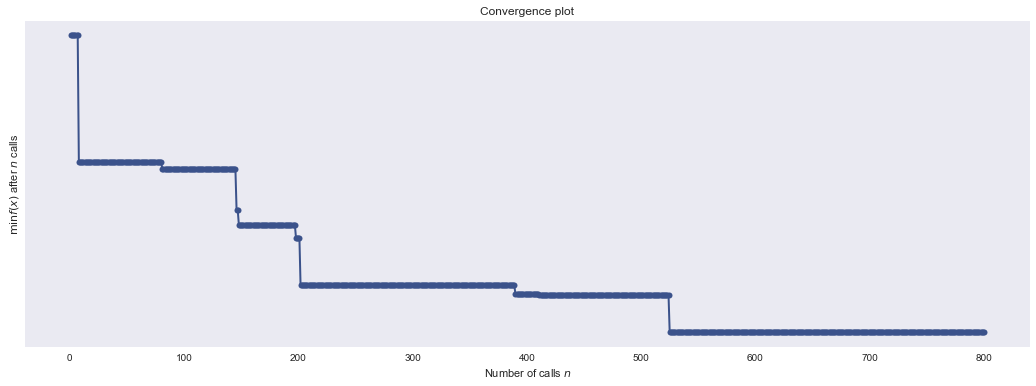

In [148]:
print('Best Params=',result.x)
print('Best Score=',result.fun)
from skopt.plots import plot_convergence
_ = plt.figure(figsize=(18,6))
_ = plot_convergence(result, yscale='log')

## XGBoost model hyperparameter search - RandomSearch with cutdown data

In [ ]:
%%time
# XGBoost with Randomized search and 5-fold CV

# Tuning Approach
# set all params to default (incl learning rate=0.1)
# tune min_child_weight and max_depth together for [1,2,3,4,5,6]
# tune gamma from 0-1
# tune subsample and colsample_bytree around 0.5-1
# tune reg_alpha, reg_lambda from 0-20

import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import mean_squared_error

params = {
      'learning_rate':    np.linspace(0.05, 0.22, 10),
      'min_child_weight': np.linspace(50, 90, 10).astype(int), 
      'max_depth':        np.linspace(10, 80, 10).astype(int), 
      'gamma':            np.linspace(0, 0.1, 3), 
      'subsample':        np.linspace(0.5, 0.8, 5), 
      'colsample_bytree': np.linspace(0.3, 1, 8), 
      'reg_alpha':        np.linspace(0, 2, 5), 
      'reg_lambda':       np.linspace(0, 45, 5),
}

XGBmodel = xgb.XGBRegressor(base_score=np.mean(ytrain_small), n_estimators=100, eval_metric='rmse', 
                            random_state=1, n_jobs=1)
                            
# XGBmodel = GridSearchCV(XGBmodel, cv=5, param_grid=params, verbose=2)
XGBmodel = RandomizedSearchCV(XGBmodel, cv=5, n_iter=500, n_jobs=-1, param_distributions=params, verbose=1, random_state=1)
XGBmodel.fit(Xtrain_small, ytrain_small)
print(XGBmodel.best_estimator_)
print(XGBmodel.best_params_)

XGBtrain_preds = XGBmodel.predict(Xtrain_small)
XGBvalid_preds = XGBmodel.predict(Xvalid)
print('\nTotal training size',len(Xtrain_small))
print('Train  RMSE =', round(np.sqrt(mean_squared_error(ytrain_small, XGBtrain_preds)),6))
print('Validn RMSE =', round(np.sqrt(mean_squared_error(yvalid, XGBvalid_preds)),6))

In [ ]:
feature_importance = pd.Series(index = Xtrain.columns, data = XGBmodel.best_estimator_.feature_importances_)
_ = feature_importance.sort_values(ascending=False).head(30).plot(kind='bar', color="r", figsize = (18,6))

In [ ]:
XGBlog_test_preds = XGBmodel.predict(Xtest)
XGBtest_preds = np.exp(XGBlog_test_preds) - 1
XGBpreds = pd.DataFrame({'id': test_id, 'trip_duration': XGBtest_preds})
XGBpreds.to_csv('XG_tuned_submission.csv.gz', index=False, compression='gzip')

## Ridge Regression
Works very poorly as larger values of distance_great_circle cause massive increases in duration predictions

In [ ]:
%%time
from sklearn.linear_model import RidgeCV, Ridge
from sklearn.metrics import mean_squared_error

# use CV to find best alpha on train data, then just plug into Ridge call below for faster runtime
#alphas = np.linspace(0.1, 5, 10)
#RRmodel = RidgeCV(cv=5, alphas=alphas, scoring='neg_mean_squared_error')

RRmodel = Ridge(alpha=2, random_state=1)
RRmodel.fit(Xtrain, ytrain)
RRtrain_preds = RRmodel.predict(Xtrain)
RRvalid_preds = RRmodel.predict(Xvalid)

RRtrain_score = round(np.sqrt(mean_squared_error(ytrain, RRtrain_preds)),6)
RRvalid_score = round(np.sqrt(mean_squared_error(yvalid, RRvalid_preds)),6)
print('Train RMSE =', RRtrain_score)
print('Test  RMSE =', RRvalid_score)
#RRmodel.alphas
#RRmodel.alpha_

# plot feature importances
feature_importance = pd.Series(index = Xtrain.columns, data = np.abs(RRmodel.coef_))
_ = feature_importance.sort_values(ascending=False).head(30).plot(kind='bar', color="r", figsize = (18,6))

In [ ]:
# create Ridge Regression file for submission
RRlog_test_preds = RRmodel.predict(Xtest)
RRtest_preds = np.abs(np.exp(RRlog_test_preds)-1)
RRpreds = pd.DataFrame({'id': test_id, 'trip_duration': RRtest_preds})
RRpreds.to_csv('RR_submission.csv.gz', index=False, compression='gzip')
print('File created')

In [ ]:
# show ridge coefficients as a function of regularisation
alphas = np.logspace(-3, 9, 15)
coefs = []
for a in alphas:
    ridge = Ridge(alpha=a, fit_intercept=False)
    _ = ridge.fit(Xtrain, ytrain)
    coefs.append(ridge.coef_)

_ = plt.figure(figsize=(18,6))
ax = plt.gca()
_ = ax.plot(alphas, coefs)
_ = ax.set_xscale('log')
_ = ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
_ = plt.xlabel('alpha')
_ = plt.ylabel('weights')
_ = plt.title('Ridge coefficients as a function of l2 regularization')

In [ ]:
# check the largest prediction record and calculate to see where overestimate is
# problem is distance_great_circle which distorts predictions for large distances
index = RRvalid_preds.argmax()
row = Xvalid.iloc[index]
result = RRmodel.intercept_
print('Intercept= ', round(result,4))
for name, item, coef in zip(feature_names, row, RRmodel.coef_):
    print('{0:25} {1:9} * {2:9} = {3:9}'.format(name, round(coef,4), round(np.float(item),4), 
                                                round(np.float(item) * coef,4)))
    result = result + np.float(item) * coef
    
print('\nPrediction= {0}, calculated result using coefficients= {1}'.format(RRvalid_preds[index], result))
Xv = scaler.inverse_transform(Xvalid)